In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
sys.path.insert(0, "C:\\Users\\KonuTech\\DataSpellProjects\\kaggle-tabular-playground-series-oct-2021\\scripts")
import json
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from statsmodels.tsa.stattools import adfuller

In [99]:
from catboost import CatBoostRegressor

In [101]:
from sklearn.metrics import mean_squared_error

In [4]:
pd.options.display.float_format = "{:.2f}".format

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
CURRENT_WORKING_DIRECTORY = os.getcwd()

In [7]:
CONFIG_FILE = "config.json"
with open(CURRENT_WORKING_DIRECTORY + "\\" + CONFIG_FILE, encoding='utf-8') as f:
    CONFIG = json.load(f)

In [8]:
TRAIN_PATH = CONFIG["INPUTS"]["TRAIN_PATH"][0]
TEST_PATH = CONFIG["INPUTS"]["TEST_PATH"][0]
TARGET = CONFIG["INPUTS"]["TARGET"]
INDEX_COL = CONFIG["INPUTS"]["INDEX_COLUMNS"]
SEP = CONFIG["INPUTS"]["SEPARATOR"]
DECIMAL = CONFIG["INPUTS"]["DECIMAL"]
ENCODING = CONFIG["INPUTS"]["ENCODING"]
DATE_COLUMNS = CONFIG["INPUTS"]["DATE_COLUMNS"]
FLOAT_PRECISION = CONFIG["INPUTS"]["FLOAT_PRECISION"]
DTYPE = CONFIG["INPUTS"]["DTYPE"]
COLUMNS_WITH_NAN_VALUES = CONFIG["INPUTS"]["COLUMNS_WITH_NAN_VALUES"]

In [9]:
INPUTS = CURRENT_WORKING_DIRECTORY + "\\INPUTS"
SCRIPTS = CURRENT_WORKING_DIRECTORY + "\\SCRIPTS"

## train overview

In [10]:
train = pd.read_csv(
    INPUTS + "\\" + TRAIN_PATH,
    index_col=INDEX_COL,
    sep=SEP,
    encoding=ENCODING,
    infer_datetime_format=True,
    engine="c",
    low_memory=False,
    parse_dates=DATE_COLUMNS,
    dtype=DTYPE
)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26298 entries, 0 to 26297
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      26298 non-null  datetime64[ns]
 1   country   26298 non-null  object        
 2   store     26298 non-null  object        
 3   product   26298 non-null  object        
 4   num_sold  26298 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.2+ MB


In [12]:
TRAIN_NUMERIC_COLUMNS = train.select_dtypes(include=["float64", "int64"]).columns
TRAIN_NUMERIC_COLUMNS = TRAIN_NUMERIC_COLUMNS.drop(TARGET)
TRAIN_NUMERIC_COLUMNS

Index([], dtype='object')

In [13]:
TRAIN_OBJECT_COLUMNS = train.select_dtypes(include=["object"]).columns
TRAIN_OBJECT_COLUMNS

Index(['country', 'store', 'product'], dtype='object')

In [14]:
train.sample(5)

date  country       store         product  num_sold
row_id                                                          
11335  2016-09-21   Sweden  KaggleMart      Kaggle Hat       301
9563   2016-06-15  Finland  KaggleRama  Kaggle Sticker       156
13329  2017-01-10   Norway  KaggleRama      Kaggle Mug       542
25291  2018-11-06  Finland  KaggleMart      Kaggle Hat       316
14646  2017-03-24   Sweden  KaggleMart      Kaggle Mug       223

## test overview

In [15]:
test = pd.read_csv(
    INPUTS + "\\" + TEST_PATH,
    index_col=INDEX_COL,
    sep=SEP,
    encoding=ENCODING,
    infer_datetime_format=True,
    engine="c",
    low_memory=False,
    parse_dates=DATE_COLUMNS,
    dtype=DTYPE
)

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6570 entries, 26298 to 32867
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     6570 non-null   datetime64[ns]
 1   country  6570 non-null   object        
 2   store    6570 non-null   object        
 3   product  6570 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 256.6+ KB


In [17]:
TEST_NUMERIC_COLUMNS = test.select_dtypes(include=["float64", "int64"]).columns
TEST_NUMERIC_COLUMNS

Index([], dtype='object')

In [18]:
TEST_OBJECT_COLUMNS = test.select_dtypes(include=["object"]).columns
TEST_OBJECT_COLUMNS

Index(['country', 'store', 'product'], dtype='object')

In [19]:
test.sample(5)

date  country       store         product
row_id                                                
30103  2019-07-31   Norway  KaggleMart      Kaggle Hat
28267  2019-04-20   Norway  KaggleMart      Kaggle Hat
27349  2019-02-28   Norway  KaggleMart      Kaggle Hat
28553  2019-05-06  Finland  KaggleRama  Kaggle Sticker
27056  2019-02-12  Finland  KaggleMart  Kaggle Sticker

## features and target

In [20]:
features = [col for col in train.columns if col not in [TARGET]]

In [21]:
X_train = train[features]

In [22]:
X_train.sample(2)

date  country       store         product
row_id                                                
24441  2018-09-19   Sweden  KaggleRama      Kaggle Mug
8285   2016-04-05  Finland  KaggleRama  Kaggle Sticker

In [23]:
y_train = train[TARGET]

In [24]:
y_train.value_counts()

189     99
177     97
185     95
183     93
186     92
        ..
1105     1
1121     1
1009     1
1343     1
2128     1
Name: num_sold, Length: 1377, dtype: int64

In [25]:
X_test = test[features]

In [26]:
X_test.sample(2)

date country       store     product
row_id                                           
28960  2019-05-28  Sweden  KaggleRama  Kaggle Hat
30073  2019-07-29  Sweden  KaggleMart  Kaggle Hat

In [27]:
print(" X_train shape: ", X_train.shape, "\n", "y_train shape: ", y_train.shape, "\n", "X_test  shape: ", X_test.shape, "\n", "y_test  shape: ", None)

 X_train shape:  (26298, 4) 
 y_train shape:  (26298,) 
 X_test  shape:  (6570, 4) 
 y_test  shape:  None


## cat features

In [28]:
categorical_features = TEST_OBJECT_COLUMNS

In [29]:
categorical_features_index = []
for column in categorical_features:
    categorical_features_index.append(X_train.columns.get_loc(column))

In [30]:
categorical_features_index

[1, 2, 3]

## cat features distinc

In [31]:
for column in range(len(train.columns)):
    print("\n")
    print(train.iloc[:,column].value_counts())



2015-01-01    18
2017-09-09    18
2017-09-07    18
2017-09-06    18
2017-09-05    18
              ..
2016-04-30    18
2016-04-29    18
2016-04-28    18
2016-04-27    18
2018-12-31    18
Name: date, Length: 1461, dtype: int64


Finland    8766
Norway     8766
Sweden     8766
Name: country, dtype: int64


KaggleMart    13149
KaggleRama    13149
Name: store, dtype: int64


Kaggle Mug        8766
Kaggle Hat        8766
Kaggle Sticker    8766
Name: product, dtype: int64


189     99
177     97
185     95
183     93
186     92
        ..
1105     1
1121     1
1009     1
1343     1
2128     1
Name: num_sold, Length: 1377, dtype: int64


## Aggregations

In [32]:
train

date  country       store         product  num_sold
row_id                                                          
0      2015-01-01  Finland  KaggleMart      Kaggle Mug       329
1      2015-01-01  Finland  KaggleMart      Kaggle Hat       520
2      2015-01-01  Finland  KaggleMart  Kaggle Sticker       146
3      2015-01-01  Finland  KaggleRama      Kaggle Mug       572
4      2015-01-01  Finland  KaggleRama      Kaggle Hat       911
...           ...      ...         ...             ...       ...
26293  2018-12-31   Sweden  KaggleMart      Kaggle Hat       823
26294  2018-12-31   Sweden  KaggleMart  Kaggle Sticker       250
26295  2018-12-31   Sweden  KaggleRama      Kaggle Mug      1004
26296  2018-12-31   Sweden  KaggleRama      Kaggle Hat      1441
26297  2018-12-31   Sweden  KaggleRama  Kaggle Sticker       388

[26298 rows x 5 columns]

In [33]:
target = pd.DataFrame()

In [34]:
#Findland
target["Mug Fin Mart"] = train[((((train["product"] == "Kaggle Mug")  & (train["country"] == "Finland")) == True) & (train["store"] == "KaggleMart") == True)].groupby("date").sum()["num_sold"]
target["Hat Fin Mart"] = train[((((train["product"] == "Kaggle Hat")  & (train["country"] == "Finland")) == True) & (train["store"] == "KaggleMart") == True)].groupby("date").sum()["num_sold"]

In [35]:
#Mug Fin Mart : Mug sold in Finland by KaggleMart
#Mug hat Mart : Hat sold in Finland by KaggleMart
#Mug sti Mart : Sitcker sold in Finland by KaggleMart...

# FINLAND :
target['Mug Fin Mart'] = train[((((train['product'] == 'Kaggle Mug') & (train['country']=='Finland'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Hat Fin Mart'] = train[((((train['product'] == 'Kaggle Hat') & (train['country']=='Finland'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Sti Fin Mart'] = train[((((train['product'] == 'Kaggle Sticker') & (train['country']=='Finland'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Mug Fin Rama'] = train[((((train['product'] == 'Kaggle Mug') & (train['country']=='Finland'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']
target['Hat Fin Rama'] = train[((((train['product'] == 'Kaggle Hat') & (train['country']=='Finland'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']
target['Sti Fin Rama'] = train[((((train['product'] == 'Kaggle Sticker') & (train['country']=='Finland'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']

# NORWAY:
target['Mug Nor Mart'] = train[((((train['product'] == 'Kaggle Mug') & (train['country']=='Norway'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Hat Nor Mart'] = train[((((train['product'] == 'Kaggle Hat') & (train['country']=='Norway'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Sti Nor Mart'] = train[((((train['product'] == 'Kaggle Sticker') & (train['country']=='Norway'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Mug Nor Rama'] = train[((((train['product'] == 'Kaggle Mug') & (train['country']=='Norway'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']
target['Hat Nor Rama'] = train[((((train['product'] == 'Kaggle Hat') & (train['country']=='Norway'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']
target['Sti Nor Rama'] = train[((((train['product'] == 'Kaggle Sticker') & (train['country']=='Norway'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']

# SWEDEN:
target['Mug Swe Mart'] = train[((((train['product'] == 'Kaggle Mug') & (train['country']=='Sweden'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Hat Swe Mart'] = train[((((train['product'] == 'Kaggle Hat') & (train['country']=='Sweden'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Sti Swe Mart'] = train[((((train['product'] == 'Kaggle Sticker') & (train['country']=='Sweden'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Mug Swe Rama'] = train[((((train['product'] == 'Kaggle Mug') & (train['country']=='Sweden'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']
target['Hat Swe Rama'] = train[((((train['product'] == 'Kaggle Hat') & (train['country']=='Sweden'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']
target['Sti Swe Rama'] = train[((((train['product'] == 'Kaggle Sticker') & (train['country']=='Sweden'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']

In [36]:
target.index = np.arange(0,target.shape[0],1).tolist()

In [37]:
target=pd.DataFrame()

#Mug Fin Mart : Mug sold in Finland by KaggleMart
#Mug hat Mart : Hat sold in Finland by KaggleMart
#Mug sti Mart : Sitcker sold in Finland by KaggleMart...

# FINLAND :
target['Mug Fin Mart'] = train[((((train['product'] == 'Kaggle Mug') & (train['country']=='Finland'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Hat Fin Mart'] = train[((((train['product'] == 'Kaggle Hat') & (train['country']=='Finland'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Sti Fin Mart'] = train[((((train['product'] == 'Kaggle Sticker') & (train['country']=='Finland'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Mug Fin Rama'] = train[((((train['product'] == 'Kaggle Mug') & (train['country']=='Finland'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']
target['Hat Fin Rama'] = train[((((train['product'] == 'Kaggle Hat') & (train['country']=='Finland'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']
target['Sti Fin Rama'] = train[((((train['product'] == 'Kaggle Sticker') & (train['country']=='Finland'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']

# NORWAY:
target['Mug Nor Mart'] = train[((((train['product'] == 'Kaggle Mug') & (train['country']=='Norway'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Hat Nor Mart'] = train[((((train['product'] == 'Kaggle Hat') & (train['country']=='Norway'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Sti Nor Mart'] = train[((((train['product'] == 'Kaggle Sticker') & (train['country']=='Norway'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Mug Nor Rama'] = train[((((train['product'] == 'Kaggle Mug') & (train['country']=='Norway'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']
target['Hat Nor Rama'] = train[((((train['product'] == 'Kaggle Hat') & (train['country']=='Norway'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']
target['Sti Nor Rama'] = train[((((train['product'] == 'Kaggle Sticker') & (train['country']=='Norway'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']

# SWEDEN:
target['Mug Swe Mart'] = train[((((train['product'] == 'Kaggle Mug') & (train['country']=='Sweden'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Hat Swe Mart'] = train[((((train['product'] == 'Kaggle Hat') & (train['country']=='Sweden'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Sti Swe Mart'] = train[((((train['product'] == 'Kaggle Sticker') & (train['country']=='Sweden'))==True) & (train['store']=='KaggleMart')==True)].groupby('date').sum()['num_sold']
target['Mug Swe Rama'] = train[((((train['product'] == 'Kaggle Mug') & (train['country']=='Sweden'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']
target['Hat Swe Rama'] = train[((((train['product'] == 'Kaggle Hat') & (train['country']=='Sweden'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']
target['Sti Swe Rama'] = train[((((train['product'] == 'Kaggle Sticker') & (train['country']=='Sweden'))==True) & (train['store']=='KaggleRama')==True)].groupby('date').sum()['num_sold']

target.index = np.arange(0,target.shape[0],1).tolist()
target

Mug Fin Mart  Hat Fin Mart  Sti Fin Mart  Mug Fin Rama  Hat Fin Rama  \
0              329           520           146           572           911   
1              318           493           127           544           794   
2              360           535           141           579           843   
3              332           544           125           582           873   
4              243           378           102           423           668   
...            ...           ...           ...           ...           ...   
1456           414           573           177           652          1068   
1457           499           841           223           895          1398   
1458           774          1107           296          1398          1895   
1459           757          1113           326          1241          1878   
1460           469           822           238           831          1231   

      Sti Fin Rama  Mug Nor Mart  Hat Nor Mart  Sti Nor Mart  Mug Nor Rama  \
0              283           526           906           250          1005   
1              249           538           845           237           949   
2              265           614           930           254          1029   
3              245           589           889           255           957   
4              187           435           671           184           739   
...            ...           ...           ...           ...           ...   
1456           308           568           898           270          1108   
1457           431           731          1162           361          1333   
1458           559          1113          1650           518          1816   
1459           554          1052          1809           500          1935   
1460           360           728          1124           351          1383   

      Hat Nor Rama  Sti Nor Rama  Mug Swe Mart  Hat Swe Mart  Sti Swe Mart  \
0             1461           395           440           624           175   
1             1446           415           384           572           155   
2             1631           451           420           630           173   
3             1540           455           406           697           169   
4             1126           310           298           442           127   
...            ...           ...           ...           ...           ...   
1456          1604           436           420           672           196   
1457          2178           662           555           874           260   
1458          2884           874           720          1106           348   
1459          2851           833           730          1133           336   
1460          2128           561           570           823           250   

      Mug Swe Rama  Hat Swe Rama  Sti Swe Rama  
0              706          1195           324  
1              653           986           293  
2              734          1167           319  
3              657          1112           300  
4              512           796           227  
...            ...           ...           ...  
1456           745          1127           319  
1457           990          1540           441  
1458          1438          2169           596  
1459          1303          2138           587  
1460          1004          1441           388  

[1461 rows x 18 columns]

In [38]:
target

Mug Fin Mart  Hat Fin Mart  Sti Fin Mart  Mug Fin Rama  Hat Fin Rama  \
0              329           520           146           572           911   
1              318           493           127           544           794   
2              360           535           141           579           843   
3              332           544           125           582           873   
4              243           378           102           423           668   
...            ...           ...           ...           ...           ...   
1456           414           573           177           652          1068   
1457           499           841           223           895          1398   
1458           774          1107           296          1398          1895   
1459           757          1113           326          1241          1878   
1460           469           822           238           831          1231   

      Sti Fin Rama  Mug Nor Mart  Hat Nor Mart  Sti Nor Mart  Mug Nor Rama  \
0              283           526           906           250          1005   
1              249           538           845           237           949   
2              265           614           930           254          1029   
3              245           589           889           255           957   
4              187           435           671           184           739   
...            ...           ...           ...           ...           ...   
1456           308           568           898           270          1108   
1457           431           731          1162           361          1333   
1458           559          1113          1650           518          1816   
1459           554          1052          1809           500          1935   
1460           360           728          1124           351          1383   

      Hat Nor Rama  Sti Nor Rama  Mug Swe Mart  Hat Swe Mart  Sti Swe Mart  \
0             1461           395           440           624           175   
1             1446           415           384           572           155   
2             1631           451           420           630           173   
3             1540           455           406           697           169   
4             1126           310           298           442           127   
...            ...           ...           ...           ...           ...   
1456          1604           436           420           672           196   
1457          2178           662           555           874           260   
1458          2884           874           720          1106           348   
1459          2851           833           730          1133           336   
1460          2128           561           570           823           250   

      Mug Swe Rama  Hat Swe Rama  Sti Swe Rama  
0              706          1195           324  
1              653           986           293  
2              734          1167           319  
3              657          1112           300  
4              512           796           227  
...            ...           ...           ...  
1456           745          1127           319  
1457           990          1540           441  
1458          1438          2169           596  
1459          1303          2138           587  
1460          1004          1441           388  

[1461 rows x 18 columns]

In [39]:
target.columns

Index(['Mug Fin Mart', 'Hat Fin Mart', 'Sti Fin Mart', 'Mug Fin Rama',
       'Hat Fin Rama', 'Sti Fin Rama', 'Mug Nor Mart', 'Hat Nor Mart',
       'Sti Nor Mart', 'Mug Nor Rama', 'Hat Nor Rama', 'Sti Nor Rama',
       'Mug Swe Mart', 'Hat Swe Mart', 'Sti Swe Mart', 'Mug Swe Rama',
       'Hat Swe Rama', 'Sti Swe Rama'],
      dtype='object')

In [40]:
Rama = [col for col in target.columns if "Rama" in col]
Rama_swe = [col for col in target.columns if ("Rama" in col) & ("Swe" in col)]
Rama_fin = [col for col in target.columns if ("Rama" in col) & ("Fin" in col)]
Rama_nor = [col for col in target.columns if ("Rama" in col) & ("Nor" in col)]

In [41]:
Mart = [col for col in target.columns if "Mart" in col]
Mart_swe = [col for col in target.columns if ("Mart" in col) & ("Swe" in col)]
Mart_fin = [col for col in target.columns if ("Mart" in col) & ("Fin" in col)]
Mart_nor = [col for col in target.columns if ("Mart" in col) & ("Nor" in col)]

In [42]:
def show_me(data):
    fig_dims = (40, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.set_theme(style="whitegrid")
    dates = pd.date_range("1 1 2015", periods=365, freq="D")
    dates = pd.date_range(start="1/1/2015", end="31/12/2018", freq="D")
    data.index = dates
    sns.lineplot(data=data, palette="tab10", linewidth=1)

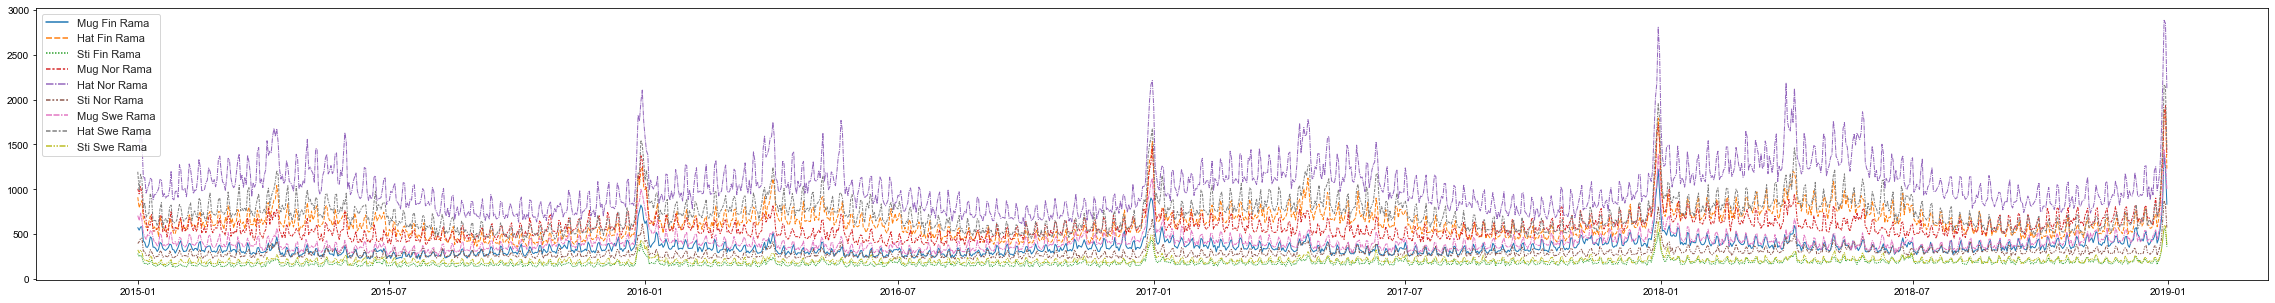

In [43]:
show_me(target[Rama])

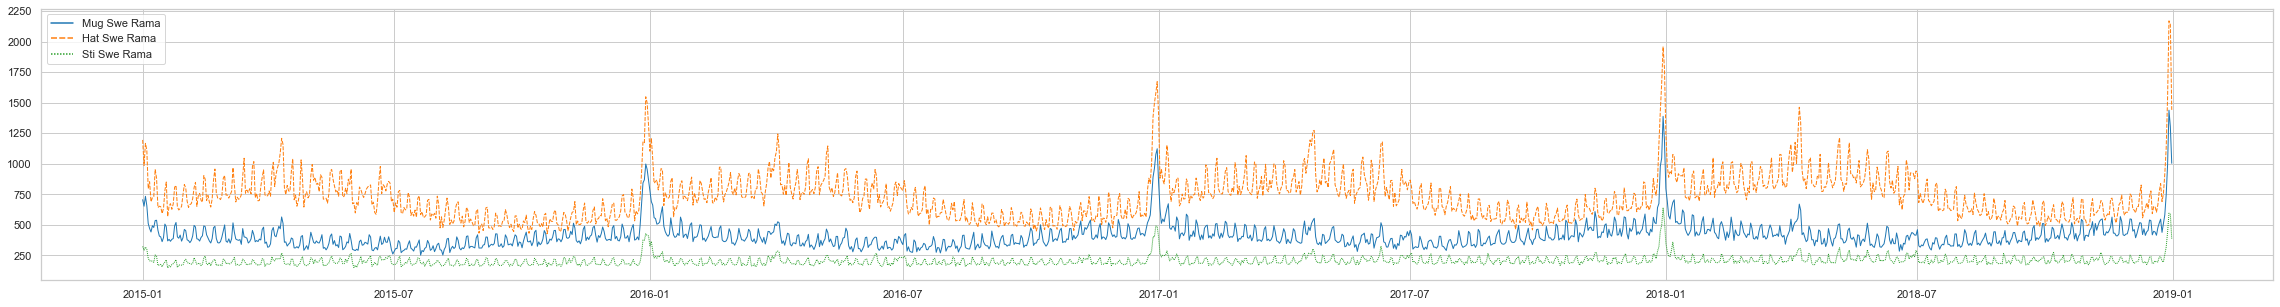

In [44]:
show_me(target[Rama_swe])

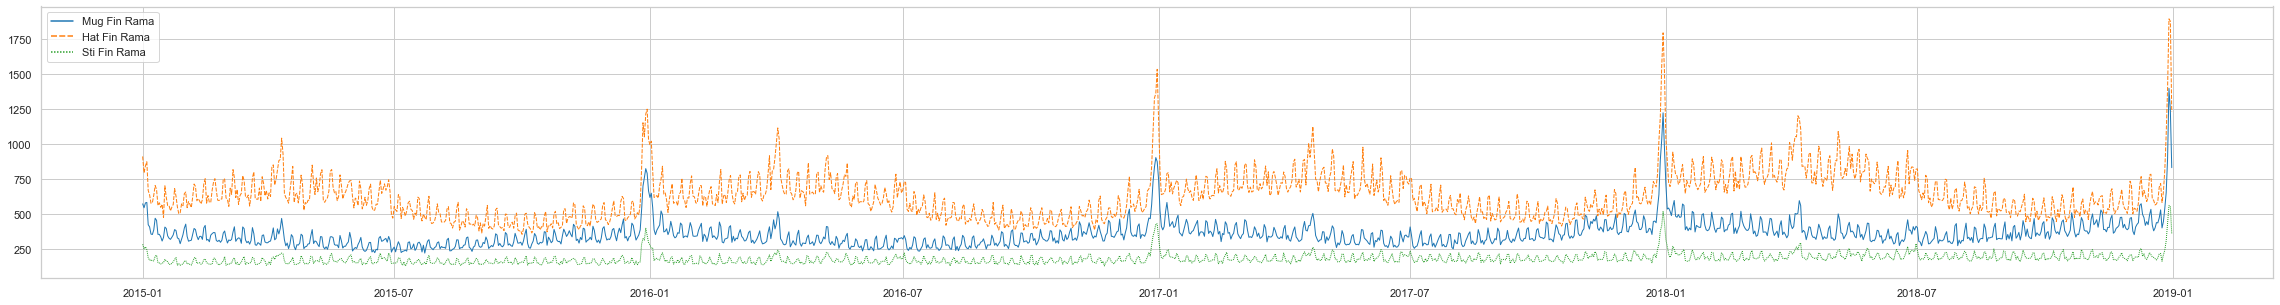

In [45]:
show_me(target[Rama_fin])

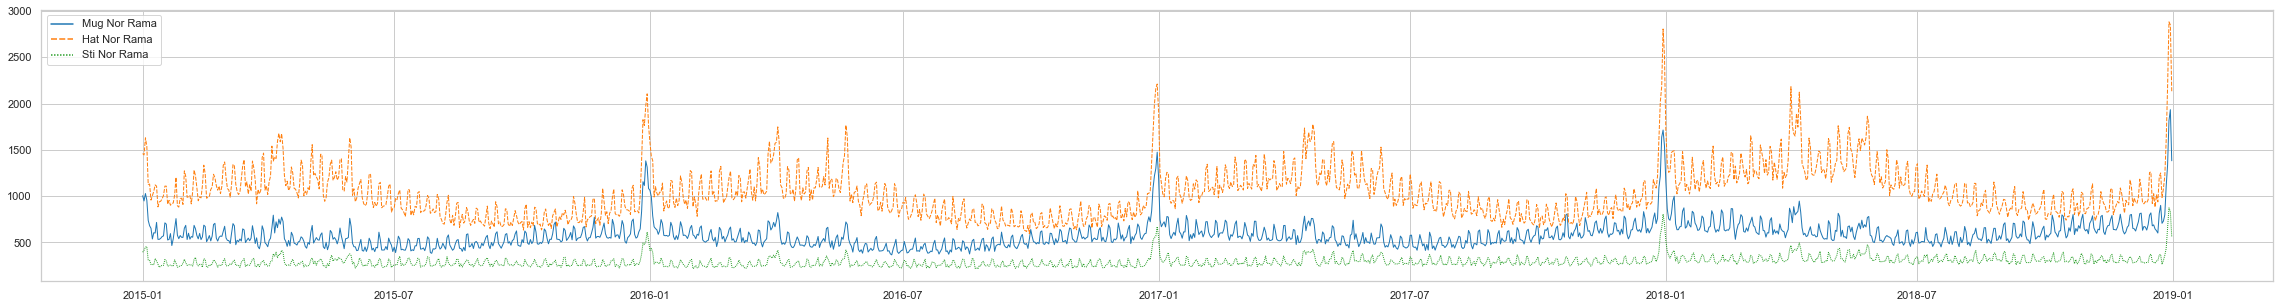

In [46]:
show_me(target[Rama_nor])

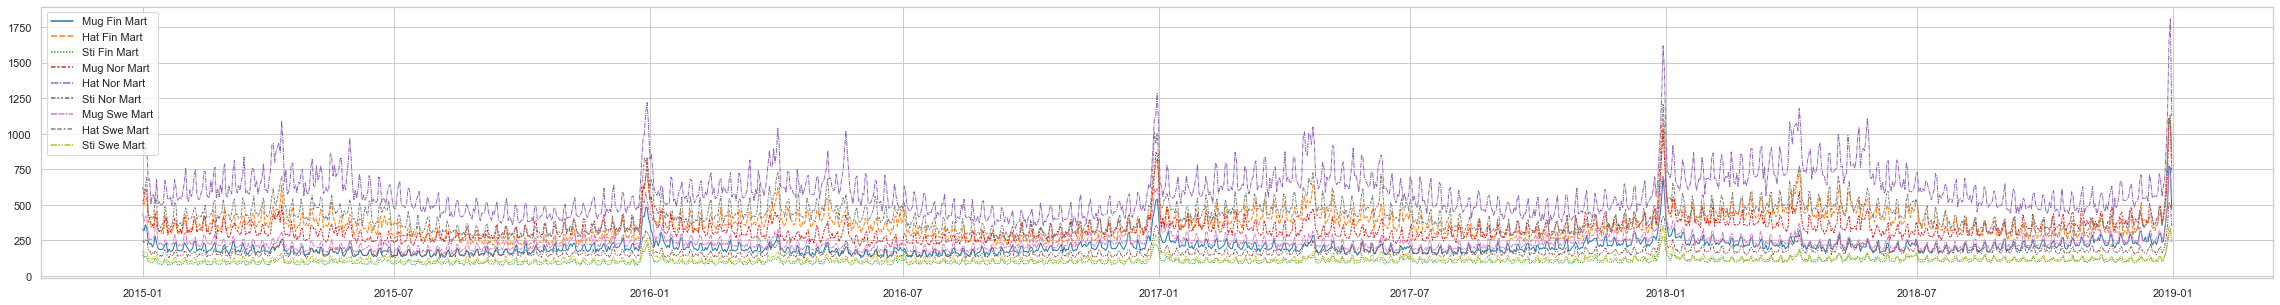

In [47]:
show_me(target[Mart])

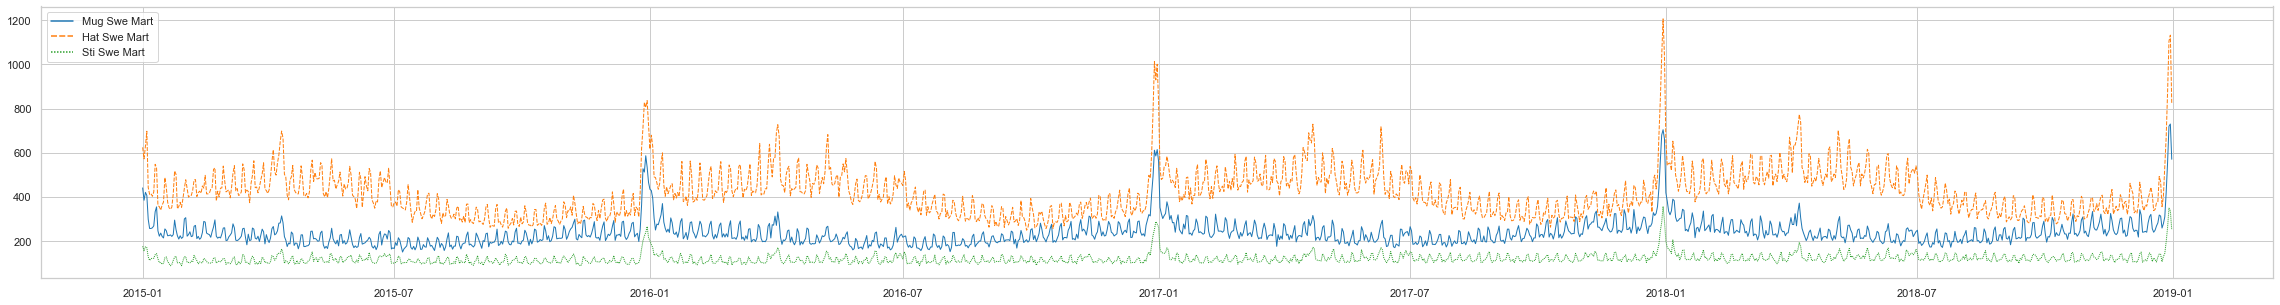

In [48]:
show_me(target[Mart_swe])

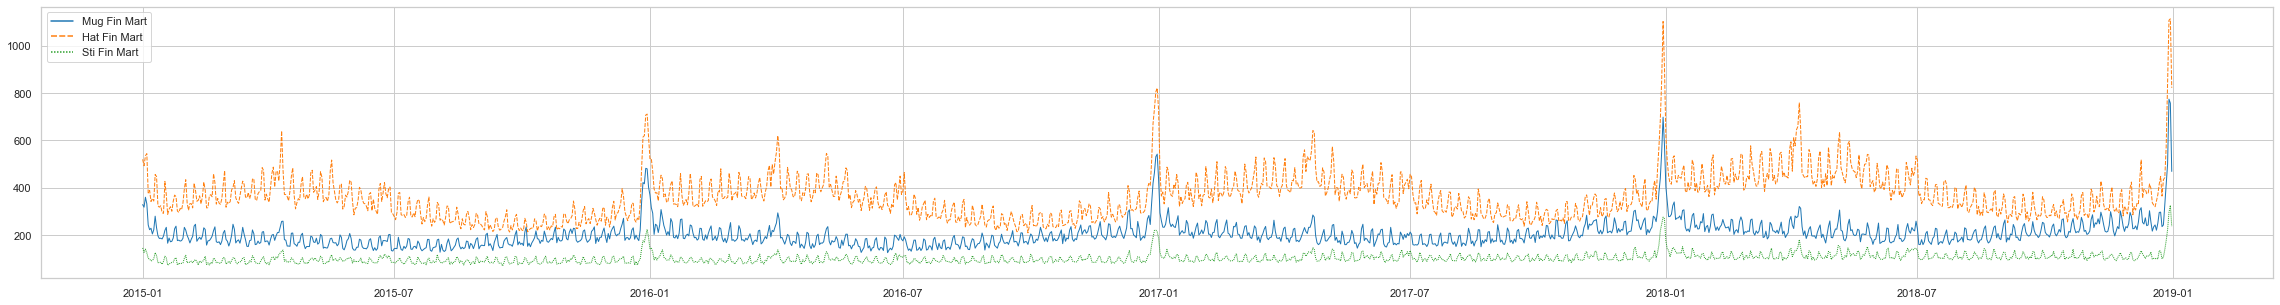

In [49]:
show_me(target[Mart_fin])

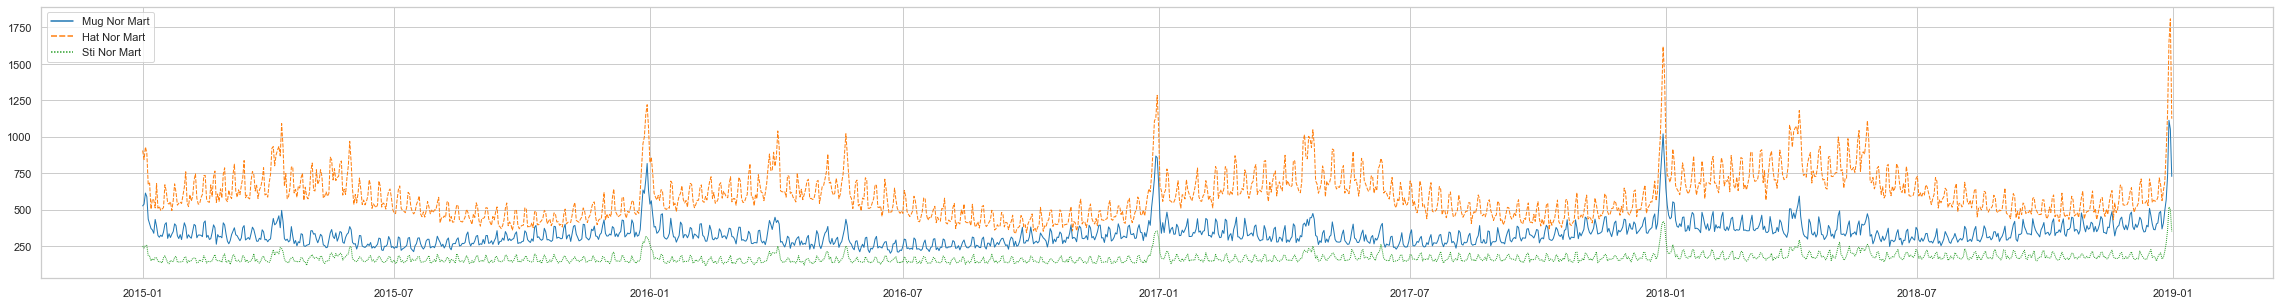

In [50]:
show_me(target[Mart_nor])

## Data Engineering

In [51]:
train_data = pd.DataFrame()

In [52]:
train_data['date'] = np.unique(train['date']).tolist()

In [53]:
train_data['date'] = pd.to_datetime(train_data['date'])

In [54]:
train_data['year'] = pd.to_datetime(train_data['date']).dt.year

In [55]:
train_data['month'] = pd.to_datetime(train_data['date']).dt.month

In [56]:
train_data['day'] = pd.to_datetime(train_data['date']).dt.day

In [57]:
train_data['dayofweek'] = pd.to_datetime(train_data['date']).dt.dayofweek

In [58]:
train_data['dayofmonth'] = pd.to_datetime(train_data['date']).dt.days_in_month

In [59]:
train_data['dayofyear'] = pd.to_datetime(train_data['date']).dt.dayofyear

In [60]:
train_data['weekday'] = pd.to_datetime(train_data['date']).dt.weekday

In [61]:
test_data = pd.DataFrame()

In [62]:
test_data['date'] = np.unique(test['date']).tolist()

In [63]:
test_data['date'] = pd.to_datetime(test_data['date'])

In [64]:
test_data['year'] = pd.to_datetime(test_data['date']).dt.year

In [65]:
test_data['month'] = pd.to_datetime(test_data['date']).dt.month

In [66]:
test_data['day'] = pd.to_datetime(test_data['date']).dt.day

In [67]:
test_data['dayofweek'] = pd.to_datetime(test_data['date']).dt.dayofweek

In [68]:
test_data['dayofmonth'] = pd.to_datetime(test_data['date']).dt.days_in_month

In [69]:
test_data['dayofyear'] = pd.to_datetime(test_data['date']).dt.dayofyear

In [70]:
test_data['weekday'] = pd.to_datetime(test_data['date']).dt.weekday

In [71]:
train_data.drop("date", axis=1, inplace=True)

In [72]:
test_data.drop("date", axis=1, inplace=True)

In [73]:
train_data.shape, test_data.shape

((1461, 7), (365, 7))

In [74]:
train_data

year  month  day  dayofweek  dayofmonth  dayofyear  weekday
0     2015      1    1          3          31          1        3
1     2015      1    2          4          31          2        4
2     2015      1    3          5          31          3        5
3     2015      1    4          6          31          4        6
4     2015      1    5          0          31          5        0
...    ...    ...  ...        ...         ...        ...      ...
1456  2018     12   27          3          31        361        3
1457  2018     12   28          4          31        362        4
1458  2018     12   29          5          31        363        5
1459  2018     12   30          6          31        364        6
1460  2018     12   31          0          31        365        0

[1461 rows x 7 columns]

## Seasonality

In [75]:
y = pd.DataFrame()

In [76]:
y["num_sold"] = target["Mug Fin Mart"]

In [77]:
y.index = pd.to_datetime(target["Mug Fin Mart"].index.tolist())

In [78]:
y

num_sold
1970-01-01 00:00:00.000000000       329
1970-01-01 00:00:00.000000001       318
1970-01-01 00:00:00.000000002       360
1970-01-01 00:00:00.000000003       332
1970-01-01 00:00:00.000000004       243
...                                 ...
1970-01-01 00:00:00.000001456       414
1970-01-01 00:00:00.000001457       499
1970-01-01 00:00:00.000001458       774
1970-01-01 00:00:00.000001459       757
1970-01-01 00:00:00.000001460       469

[1461 rows x 1 columns]

In [79]:
dftest = adfuller(y, autolag="AIC")

In [80]:
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])

1. ADF :  -2.2005381767211287
2. P-Value :  0.20605018773564754


P_value > 0.05 not stationary

In [81]:
figsize=(40, 5)

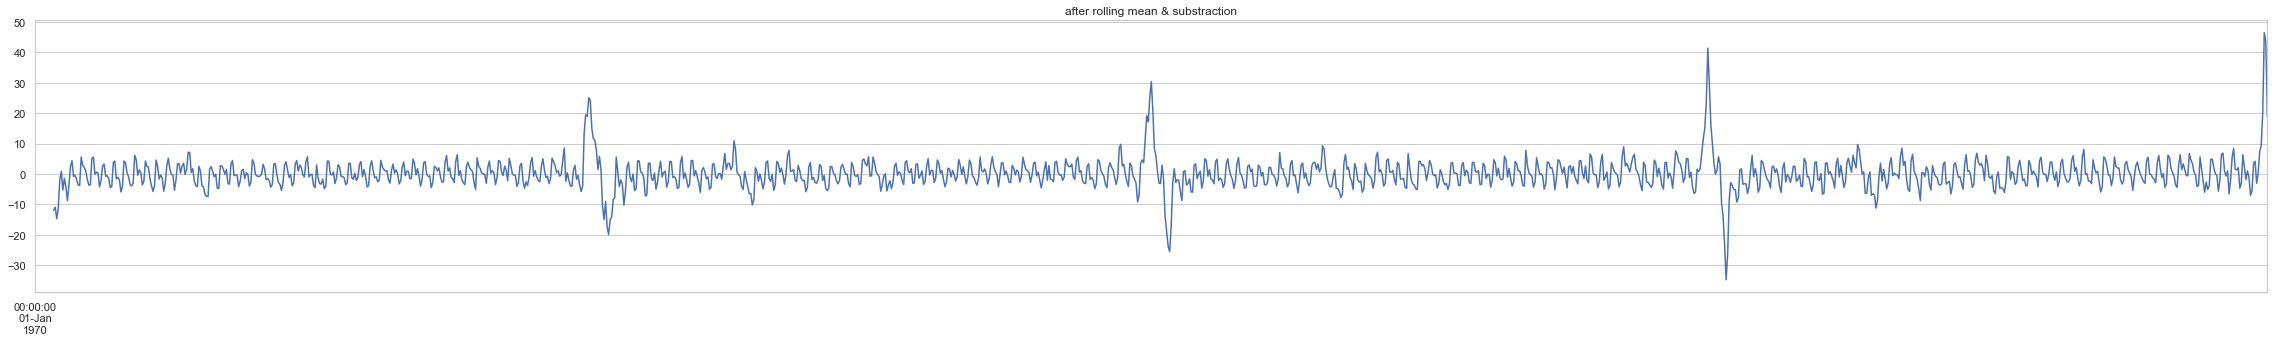

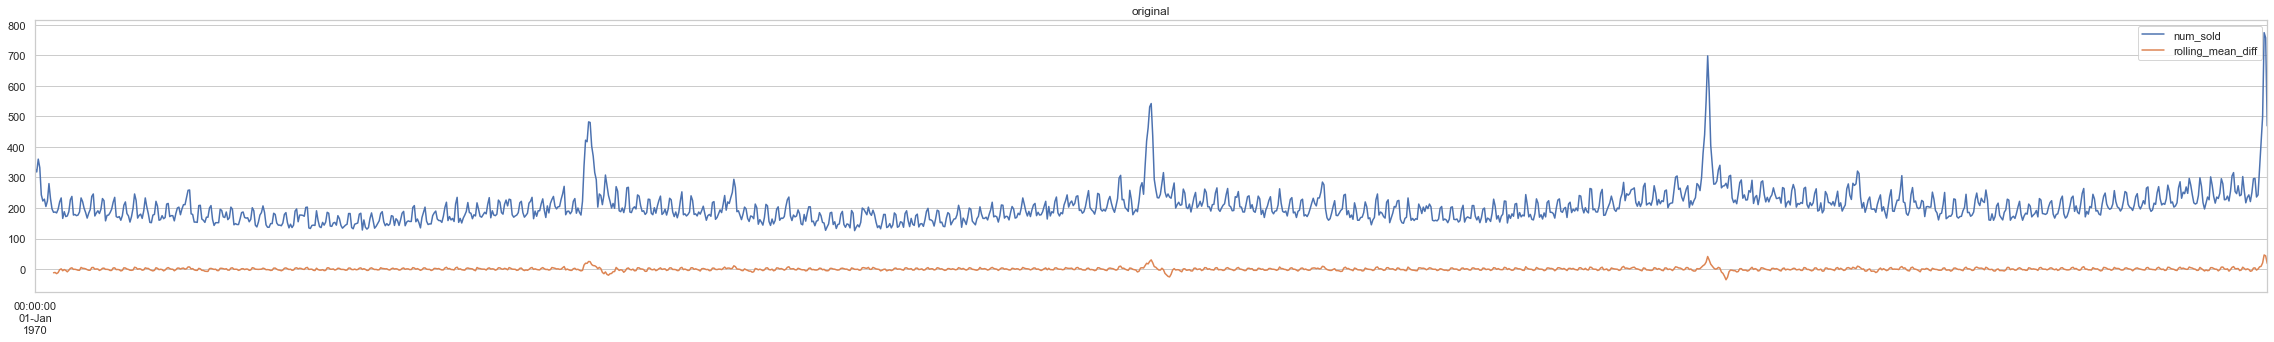

In [82]:
rolling_mean = y.rolling(window = 12).mean()
y['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
y['rolling_mean_diff'].plot(title='after rolling mean & substraction', figsize=figsize);
ax2 = plt.subplot()
y.plot(title='original', figsize=figsize);

In [83]:
dftest = adfuller(y['rolling_mean_diff'].dropna(), autolag="AIC")
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])

1. ADF :  -7.035799410203436
2. P-Value :  6.020982907009707e-10


## train with one year, evaluate with next year

In [84]:
y = pd.DataFrame()

In [85]:
y["num_sold"] = target["Mug Fin Mart"]

In [86]:
y.index = target.index

In [87]:
i=0

In [88]:
index_train_start = i * 365

In [89]:
index_train_end = (i + 1) * 365

In [90]:
index_valid_start = (i + 1) * 365

In [91]:
index_valid_end = (i + 2) * 365

## 2015-2016

<AxesSubplot:>

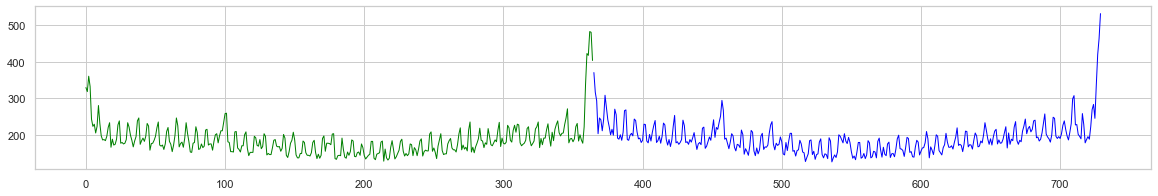

In [92]:
y["num_sold"].iloc[index_train_start:index_valid_start].plot(figsize=(20, 3), linewidth=1, color="green")
y["num_sold"].iloc[index_valid_start:index_valid_end].plot(figsize=(20, 3), linewidth=1, color="blue")

## 2016-2017

<AxesSubplot:>

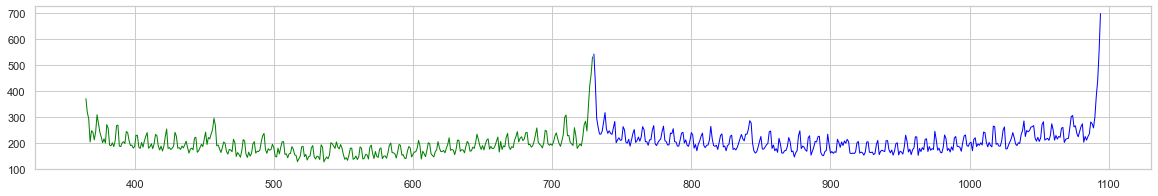

In [93]:
i=1
index_train_start = i*365
index_train_end = (1+i)*365
index_valid_start = (1+i)*365
index_valid_end = (2+i)*365
y['num_sold'].iloc[index_train_start:index_valid_start].plot(figsize=(20,3),linewidth=1, color='green')
y['num_sold'].iloc[index_valid_start:index_valid_end].plot(figsize=(20,3),linewidth=1,color='blue')

## 2017-2018

<AxesSubplot:>

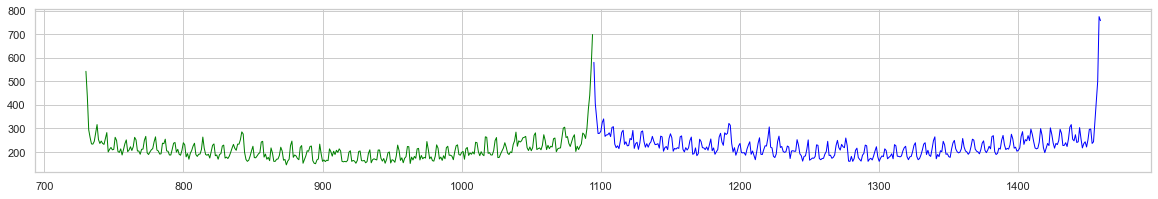

In [94]:
i=2
index_train_start = i*365
index_train_end = (1+i)*365
index_valid_start = (1+i)*365
index_valid_end = (2+i)*365
y['num_sold'].iloc[index_train_start:index_valid_start].plot(figsize=(20, 3),linewidth=1, color='green')
y['num_sold'].iloc[index_valid_start:index_valid_end].plot(figsize=(20, 3),linewidth=1,color='blue')

## 2015-2016

<AxesSubplot:>

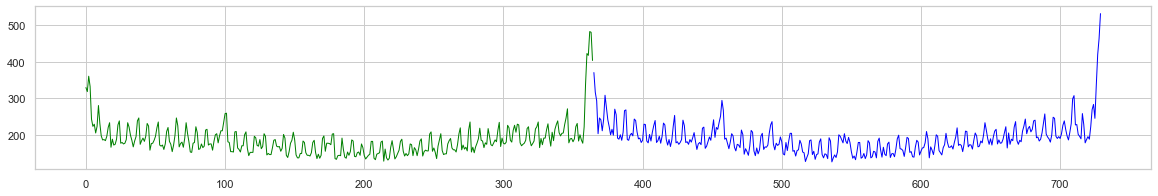

In [95]:
# Green = Training
# Blue = validation set
INDEX =train_data.index.tolist()
i=0
index_train_start = 0
index_train_end = (1+i)*365
index_valid_start = (1+i)*365
index_valid_end = (2+i)*365
y['num_sold'].iloc[index_train_start:index_valid_start].plot(figsize=(20, 3),linewidth=1, color='green')
y['num_sold'].iloc[index_valid_start:index_valid_end].plot(figsize=(20, 3),linewidth=1,color='blue')

## 2015-2017

<AxesSubplot:>

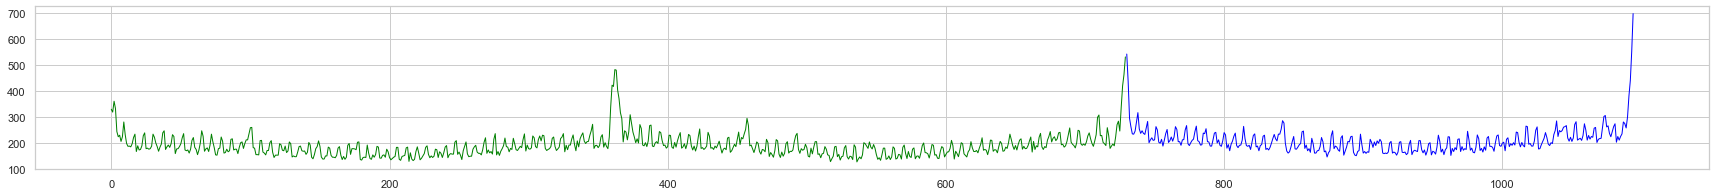

In [96]:
i=1
index_train_start = 0
index_train_end = (1+i)*365
index_valid_start = (1+i)*365
index_valid_end = (2+i)*365
y['num_sold'].iloc[index_train_start:index_valid_start].plot(figsize=(30, 3),linewidth=1, color='green')
y['num_sold'].iloc[index_valid_start:index_valid_end].plot(figsize=(30, 3),linewidth=1,color='blue')

## 2015-2018

<AxesSubplot:>

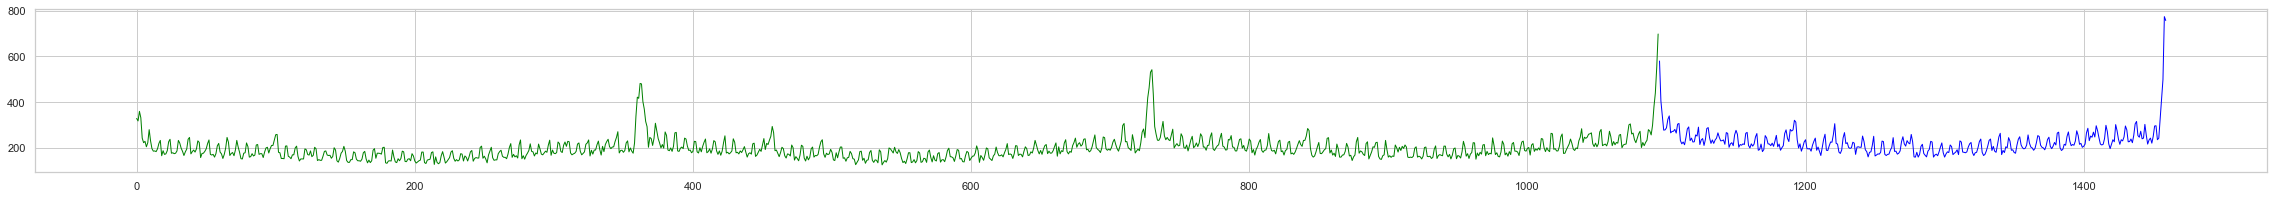

In [97]:
i=2
index_train_start = 0
index_train_end = (1+i)*365
index_valid_start = (1+i)*365
index_valid_end = (2+i)*365
y['num_sold'].iloc[index_train_start:index_valid_start].plot(figsize=(40, 3),linewidth=1, color='green')
y['num_sold'].iloc[index_valid_start:index_valid_end].plot(figsize=(40, 3),linewidth=1,color='blue')

# Training

In [103]:
score_pred =[]

train_pred = np.zeros((3 * 365, 18))
test_pred_cumulative = np.zeros((test_data.shape[0], 18))

for i in range (3):
    
    index_train_start = 0
    index_train_end = (1 + i) * 365
    index_valid_start = (1 + i) * 365
    index_valid_end = (2 + i) * 365

    X_train, y_train = train_data.iloc[index_train_start:index_valid_start], target.iloc[index_train_start:index_valid_start]
    X_valid, y_valid = train_data.iloc[index_valid_start:index_valid_end], target.iloc[index_valid_start:index_valid_end]
    
    param1 = {   
        'learning_rate': 0.004280047845210125, 
        'depth': 5, 
        'l2_leaf_reg': 0.0010555278350981901, 
        'loss_function': 'MultiRMSE', 
        'eval_metric': 'MultiRMSE', 
        'task_type': 'CPU', 
        'iterations': 16962
        }
    
    clf = CatBoostRegressor(**param1)
    
    clf.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds = 1000,
        verbose=1
    )
    
    pred=clf.predict(X_valid)
    
    train_pred[i * 365 : (1 + i) * 365] = pred
    
    score = np.round(mean_squared_error(y_valid, pred))
    score_pred.append(score)
    print("fold", i + 1 ,"score MSE =", score, "RMSE =", np.round(np.sqrt(score)))
    
    pred_test = clf.predict(test_data)
    test_pred_cumulative += pred_test/3

score_total_mse = np.round((mean_squared_error(train_pred, target.iloc[366:,:])))
    
print(70*'*')
print('Score oof MSE   =', score_total_mse)
print('Score oof RMSE  =', np.round(np.sqrt(score_total_mse)))
print('Score mean MSE  =', np.round(np.mean(score_pred)))
print('Score mean RMSE =', np.round(np.sqrt(np.mean(score_pred))))
print(70*'*')  

0:	learn: 440.9013013	test: 431.0443611	best: 431.0443611 (0)	total: 5.34ms	remaining: 1m 30s
1:	learn: 439.5024826	test: 429.7334194	best: 429.7334194 (1)	total: 10.4ms	remaining: 1m 27s
2:	learn: 438.0640325	test: 428.4783874	best: 428.4783874 (2)	total: 15ms	remaining: 1m 24s
3:	learn: 436.6921807	test: 427.1602457	best: 427.1602457 (3)	total: 19.9ms	remaining: 1m 24s
4:	learn: 435.3547349	test: 425.8783541	best: 425.8783541 (4)	total: 22.8ms	remaining: 1m 17s
5:	learn: 434.4141748	test: 424.9420925	best: 424.9420925 (5)	total: 27.5ms	remaining: 1m 17s
6:	learn: 433.0065409	test: 423.6042473	best: 423.6042473 (6)	total: 32.3ms	remaining: 1m 18s
7:	learn: 431.7675148	test: 422.3648172	best: 422.3648172 (7)	total: 37.2ms	remaining: 1m 18s
8:	learn: 430.6287945	test: 421.3070799	best: 421.3070799 (8)	total: 42ms	remaining: 1m 19s
9:	learn: 429.2965073	test: 420.0259051	best: 420.0259051 (9)	total: 46.4ms	remaining: 1m 18s
10:	learn: 428.1256815	test: 418.9061731	best: 418.9061731 (10)	

99:	learn: 338.5813113	test: 337.0441901	best: 337.0441901 (99)	total: 538ms	remaining: 1m 30s
100:	learn: 337.6627981	test: 336.2167956	best: 336.2167956 (100)	total: 543ms	remaining: 1m 30s
101:	learn: 336.6961586	test: 335.3969974	best: 335.3969974 (101)	total: 547ms	remaining: 1m 30s
102:	learn: 335.7850051	test: 334.5910220	best: 334.5910220 (102)	total: 552ms	remaining: 1m 30s
103:	learn: 334.9070962	test: 333.8003240	best: 333.8003240 (103)	total: 557ms	remaining: 1m 30s
104:	learn: 334.1493581	test: 333.1675157	best: 333.1675157 (104)	total: 561ms	remaining: 1m 30s
105:	learn: 333.6673079	test: 332.7017688	best: 332.7017688 (105)	total: 568ms	remaining: 1m 30s
106:	learn: 332.8202049	test: 331.9409440	best: 331.9409440 (106)	total: 573ms	remaining: 1m 30s
107:	learn: 332.0515625	test: 331.2399512	best: 331.2399512 (107)	total: 577ms	remaining: 1m 30s
108:	learn: 331.1336150	test: 330.4812130	best: 330.4812130 (108)	total: 582ms	remaining: 1m 30s
109:	learn: 330.2037899	test: 32

202:	learn: 270.8894067	test: 278.8951638	best: 278.8951638 (202)	total: 1.07s	remaining: 1m 28s
203:	learn: 270.3106938	test: 278.4451592	best: 278.4451592 (203)	total: 1.08s	remaining: 1m 28s
204:	learn: 269.8480850	test: 278.1268079	best: 278.1268079 (204)	total: 1.09s	remaining: 1m 28s
205:	learn: 269.2710818	test: 277.7058261	best: 277.7058261 (205)	total: 1.09s	remaining: 1m 28s
206:	learn: 268.7369460	test: 277.2995145	best: 277.2995145 (206)	total: 1.1s	remaining: 1m 28s
207:	learn: 268.1344957	test: 276.7900572	best: 276.7900572 (207)	total: 1.1s	remaining: 1m 28s
208:	learn: 267.5935595	test: 276.4251609	best: 276.4251609 (208)	total: 1.11s	remaining: 1m 28s
209:	learn: 267.0735603	test: 276.0466702	best: 276.0466702 (209)	total: 1.11s	remaining: 1m 28s
210:	learn: 266.4752635	test: 275.5568548	best: 275.5568548 (210)	total: 1.12s	remaining: 1m 28s
211:	learn: 265.9390645	test: 275.1204720	best: 275.1204720 (211)	total: 1.12s	remaining: 1m 28s
212:	learn: 265.6119707	test: 27

300:	learn: 229.3136603	test: 246.6444779	best: 246.6444779 (300)	total: 1.61s	remaining: 1m 29s
301:	learn: 229.0323628	test: 246.4340491	best: 246.4340491 (301)	total: 1.61s	remaining: 1m 29s
302:	learn: 228.6815235	test: 246.2250959	best: 246.2250959 (302)	total: 1.62s	remaining: 1m 29s
303:	learn: 228.4052754	test: 245.9937423	best: 245.9937423 (303)	total: 1.63s	remaining: 1m 29s
304:	learn: 228.0060951	test: 245.7271107	best: 245.7271107 (304)	total: 1.63s	remaining: 1m 29s
305:	learn: 227.6407761	test: 245.4503397	best: 245.4503397 (305)	total: 1.64s	remaining: 1m 29s
306:	learn: 227.2602801	test: 245.1666713	best: 245.1666713 (306)	total: 1.64s	remaining: 1m 29s
307:	learn: 226.9927463	test: 244.9598913	best: 244.9598913 (307)	total: 1.65s	remaining: 1m 29s
308:	learn: 226.6220159	test: 244.6884460	best: 244.6884460 (308)	total: 1.65s	remaining: 1m 29s
309:	learn: 226.2850522	test: 244.3825154	best: 244.3825154 (309)	total: 1.66s	remaining: 1m 29s
310:	learn: 225.9906996	test: 

398:	learn: 200.7208335	test: 226.4611341	best: 226.4611341 (398)	total: 2.14s	remaining: 1m 28s
399:	learn: 200.5461474	test: 226.3532985	best: 226.3532985 (399)	total: 2.15s	remaining: 1m 28s
400:	learn: 200.2876337	test: 226.2193113	best: 226.2193113 (400)	total: 2.15s	remaining: 1m 28s
401:	learn: 200.1308369	test: 226.1091223	best: 226.1091223 (401)	total: 2.16s	remaining: 1m 28s
402:	learn: 199.8558540	test: 225.9422798	best: 225.9422798 (402)	total: 2.16s	remaining: 1m 28s
403:	learn: 199.6908845	test: 225.8350620	best: 225.8350620 (403)	total: 2.17s	remaining: 1m 28s
404:	learn: 199.3856629	test: 225.6415232	best: 225.6415232 (404)	total: 2.17s	remaining: 1m 28s
405:	learn: 199.1525493	test: 225.4877949	best: 225.4877949 (405)	total: 2.17s	remaining: 1m 28s
406:	learn: 198.8563856	test: 225.2475979	best: 225.2475979 (406)	total: 2.18s	remaining: 1m 28s
407:	learn: 198.6183170	test: 225.0875513	best: 225.0875513 (407)	total: 2.19s	remaining: 1m 28s
408:	learn: 198.4071511	test: 

498:	learn: 180.6213523	test: 214.3623570	best: 214.3623570 (498)	total: 2.68s	remaining: 1m 28s
499:	learn: 180.4578216	test: 214.2471167	best: 214.2471167 (499)	total: 2.69s	remaining: 1m 28s
500:	learn: 180.2700127	test: 214.1435413	best: 214.1435413 (500)	total: 2.69s	remaining: 1m 28s
501:	learn: 180.0696941	test: 214.0449319	best: 214.0449319 (501)	total: 2.7s	remaining: 1m 28s
502:	learn: 179.8452949	test: 213.9065478	best: 213.9065478 (502)	total: 2.7s	remaining: 1m 28s
503:	learn: 179.6850963	test: 213.8211243	best: 213.8211243 (503)	total: 2.71s	remaining: 1m 28s
504:	learn: 179.5326468	test: 213.7537923	best: 213.7537923 (504)	total: 2.71s	remaining: 1m 28s
505:	learn: 179.4013974	test: 213.6792641	best: 213.6792641 (505)	total: 2.72s	remaining: 1m 28s
506:	learn: 179.2783870	test: 213.6061983	best: 213.6061983 (506)	total: 2.73s	remaining: 1m 28s
507:	learn: 179.1038265	test: 213.4766929	best: 213.4766929 (507)	total: 2.73s	remaining: 1m 28s
508:	learn: 178.9466864	test: 21

595:	learn: 165.7404674	test: 207.1887238	best: 207.1887238 (595)	total: 3.22s	remaining: 1m 28s
596:	learn: 165.5948633	test: 207.1255353	best: 207.1255353 (596)	total: 3.22s	remaining: 1m 28s
597:	learn: 165.4836042	test: 207.0974798	best: 207.0974798 (597)	total: 3.23s	remaining: 1m 28s
598:	learn: 165.4069765	test: 207.0755600	best: 207.0755600 (598)	total: 3.23s	remaining: 1m 28s
599:	learn: 165.2503254	test: 206.9967906	best: 206.9967906 (599)	total: 3.24s	remaining: 1m 28s
600:	learn: 165.1144385	test: 206.9343102	best: 206.9343102 (600)	total: 3.24s	remaining: 1m 28s
601:	learn: 164.9571746	test: 206.8828985	best: 206.8828985 (601)	total: 3.25s	remaining: 1m 28s
602:	learn: 164.8739688	test: 206.8455935	best: 206.8455935 (602)	total: 3.25s	remaining: 1m 28s
603:	learn: 164.7551654	test: 206.7945207	best: 206.7945207 (603)	total: 3.26s	remaining: 1m 28s
604:	learn: 164.5932667	test: 206.7513113	best: 206.7513113 (604)	total: 3.27s	remaining: 1m 28s
605:	learn: 164.4759103	test: 

694:	learn: 154.4595834	test: 202.7716698	best: 202.7716698 (694)	total: 3.75s	remaining: 1m 27s
695:	learn: 154.3740131	test: 202.7292016	best: 202.7292016 (695)	total: 3.75s	remaining: 1m 27s
696:	learn: 154.3168796	test: 202.7137287	best: 202.7137287 (696)	total: 3.76s	remaining: 1m 27s
697:	learn: 154.2235869	test: 202.6697938	best: 202.6697938 (697)	total: 3.76s	remaining: 1m 27s
698:	learn: 154.1338195	test: 202.6152522	best: 202.6152522 (698)	total: 3.77s	remaining: 1m 27s
699:	learn: 154.0304197	test: 202.5708308	best: 202.5708308 (699)	total: 3.77s	remaining: 1m 27s
700:	learn: 153.9626990	test: 202.5164920	best: 202.5164920 (700)	total: 3.78s	remaining: 1m 27s
701:	learn: 153.8458671	test: 202.4601215	best: 202.4601215 (701)	total: 3.78s	remaining: 1m 27s
702:	learn: 153.7726476	test: 202.4501722	best: 202.4501722 (702)	total: 3.79s	remaining: 1m 27s
703:	learn: 153.6614403	test: 202.3997875	best: 202.3997875 (703)	total: 3.79s	remaining: 1m 27s
704:	learn: 153.5825864	test: 

792:	learn: 144.7144120	test: 200.3085156	best: 200.3085156 (792)	total: 4.29s	remaining: 1m 27s
793:	learn: 144.6571007	test: 200.2931120	best: 200.2931120 (793)	total: 4.29s	remaining: 1m 27s
794:	learn: 144.5906978	test: 200.2833160	best: 200.2833160 (794)	total: 4.3s	remaining: 1m 27s
795:	learn: 144.5170878	test: 200.2475937	best: 200.2475937 (795)	total: 4.31s	remaining: 1m 27s
796:	learn: 144.4042708	test: 200.2073740	best: 200.2073740 (796)	total: 4.31s	remaining: 1m 27s
797:	learn: 144.3451777	test: 200.1971672	best: 200.1971672 (797)	total: 4.32s	remaining: 1m 27s
798:	learn: 144.2568370	test: 200.1868309	best: 200.1868309 (798)	total: 4.32s	remaining: 1m 27s
799:	learn: 144.1206623	test: 200.1936087	best: 200.1868309 (798)	total: 4.33s	remaining: 1m 27s
800:	learn: 144.0384637	test: 200.1602012	best: 200.1602012 (800)	total: 4.33s	remaining: 1m 27s
801:	learn: 143.9777207	test: 200.1519267	best: 200.1519267 (801)	total: 4.34s	remaining: 1m 27s
802:	learn: 143.9382308	test: 2

885:	learn: 137.7186665	test: 198.9809157	best: 198.9809157 (885)	total: 4.82s	remaining: 1m 27s
886:	learn: 137.6694894	test: 198.9531633	best: 198.9531633 (886)	total: 4.82s	remaining: 1m 27s
887:	learn: 137.6096004	test: 198.9412547	best: 198.9412547 (887)	total: 4.83s	remaining: 1m 27s
888:	learn: 137.4519194	test: 198.9413057	best: 198.9412547 (887)	total: 4.83s	remaining: 1m 27s
889:	learn: 137.3117208	test: 198.9675817	best: 198.9412547 (887)	total: 4.84s	remaining: 1m 27s
890:	learn: 137.2622651	test: 198.9597546	best: 198.9412547 (887)	total: 4.84s	remaining: 1m 27s
891:	learn: 137.2076019	test: 198.9734110	best: 198.9412547 (887)	total: 4.85s	remaining: 1m 27s
892:	learn: 137.1522859	test: 198.9729102	best: 198.9412547 (887)	total: 4.86s	remaining: 1m 27s
893:	learn: 137.1428381	test: 198.9682477	best: 198.9412547 (887)	total: 4.86s	remaining: 1m 27s
894:	learn: 137.0275319	test: 198.9393723	best: 198.9393723 (894)	total: 4.86s	remaining: 1m 27s
895:	learn: 136.9675005	test: 

981:	learn: 131.6229379	test: 198.5312746	best: 198.5080832 (980)	total: 5.36s	remaining: 1m 27s
982:	learn: 131.5743620	test: 198.5145002	best: 198.5080832 (980)	total: 5.36s	remaining: 1m 27s
983:	learn: 131.5375636	test: 198.4910619	best: 198.4910619 (983)	total: 5.37s	remaining: 1m 27s
984:	learn: 131.4836860	test: 198.4946285	best: 198.4910619 (983)	total: 5.37s	remaining: 1m 27s
985:	learn: 131.4400710	test: 198.4799609	best: 198.4799609 (985)	total: 5.38s	remaining: 1m 27s
986:	learn: 131.4031996	test: 198.4748644	best: 198.4748644 (986)	total: 5.38s	remaining: 1m 27s
987:	learn: 131.3281224	test: 198.4724325	best: 198.4724325 (987)	total: 5.39s	remaining: 1m 27s
988:	learn: 131.2883009	test: 198.4693948	best: 198.4693948 (988)	total: 5.39s	remaining: 1m 27s
989:	learn: 131.1594768	test: 198.5162817	best: 198.4693948 (988)	total: 5.4s	remaining: 1m 27s
990:	learn: 131.0802709	test: 198.5018400	best: 198.4693948 (988)	total: 5.41s	remaining: 1m 27s
991:	learn: 131.0437117	test: 1

1074:	learn: 126.4647223	test: 198.4157299	best: 198.3358382 (1038)	total: 5.89s	remaining: 1m 27s
1075:	learn: 126.4269083	test: 198.4114367	best: 198.3358382 (1038)	total: 5.9s	remaining: 1m 27s
1076:	learn: 126.3058141	test: 198.4532941	best: 198.3358382 (1038)	total: 5.9s	remaining: 1m 27s
1077:	learn: 126.2704935	test: 198.4391167	best: 198.3358382 (1038)	total: 5.91s	remaining: 1m 27s
1078:	learn: 126.2166644	test: 198.4635061	best: 198.3358382 (1038)	total: 5.92s	remaining: 1m 27s
1079:	learn: 126.1869012	test: 198.4534163	best: 198.3358382 (1038)	total: 5.92s	remaining: 1m 27s
1080:	learn: 126.1393165	test: 198.4553728	best: 198.3358382 (1038)	total: 5.93s	remaining: 1m 27s
1081:	learn: 126.0258282	test: 198.4833541	best: 198.3358382 (1038)	total: 5.93s	remaining: 1m 27s
1082:	learn: 125.9902983	test: 198.4584231	best: 198.3358382 (1038)	total: 5.94s	remaining: 1m 27s
1083:	learn: 125.9641664	test: 198.4570134	best: 198.3358382 (1038)	total: 5.94s	remaining: 1m 27s
1084:	learn:

1164:	learn: 122.3622881	test: 198.3694871	best: 198.3358382 (1038)	total: 6.42s	remaining: 1m 27s
1165:	learn: 122.3235030	test: 198.3636501	best: 198.3358382 (1038)	total: 6.43s	remaining: 1m 27s
1166:	learn: 122.2767055	test: 198.3470372	best: 198.3358382 (1038)	total: 6.44s	remaining: 1m 27s
1167:	learn: 122.2421046	test: 198.3353694	best: 198.3353694 (1167)	total: 6.44s	remaining: 1m 27s
1168:	learn: 122.1967174	test: 198.3395155	best: 198.3353694 (1167)	total: 6.45s	remaining: 1m 27s
1169:	learn: 122.1571452	test: 198.3372027	best: 198.3353694 (1167)	total: 6.45s	remaining: 1m 27s
1170:	learn: 122.1324176	test: 198.3412941	best: 198.3353694 (1167)	total: 6.46s	remaining: 1m 27s
1171:	learn: 122.0231228	test: 198.3918266	best: 198.3353694 (1167)	total: 6.47s	remaining: 1m 27s
1172:	learn: 121.9947279	test: 198.3872664	best: 198.3353694 (1167)	total: 6.47s	remaining: 1m 27s
1173:	learn: 121.9658252	test: 198.3846169	best: 198.3353694 (1167)	total: 6.48s	remaining: 1m 27s
1174:	lear

1260:	learn: 118.2304553	test: 198.9447329	best: 198.3353694 (1167)	total: 6.96s	remaining: 1m 26s
1261:	learn: 118.1899217	test: 198.9403083	best: 198.3353694 (1167)	total: 6.96s	remaining: 1m 26s
1262:	learn: 118.1543865	test: 198.9439335	best: 198.3353694 (1167)	total: 6.97s	remaining: 1m 26s
1263:	learn: 118.1225628	test: 198.9381332	best: 198.3353694 (1167)	total: 6.97s	remaining: 1m 26s
1264:	learn: 118.0991157	test: 198.9300310	best: 198.3353694 (1167)	total: 6.98s	remaining: 1m 26s
1265:	learn: 118.0905636	test: 198.9193305	best: 198.3353694 (1167)	total: 6.98s	remaining: 1m 26s
1266:	learn: 118.0636091	test: 198.9176871	best: 198.3353694 (1167)	total: 6.99s	remaining: 1m 26s
1267:	learn: 118.0190467	test: 198.9102031	best: 198.3353694 (1167)	total: 6.99s	remaining: 1m 26s
1268:	learn: 117.9904483	test: 198.9130380	best: 198.3353694 (1167)	total: 7s	remaining: 1m 26s
1269:	learn: 117.9603840	test: 198.9190796	best: 198.3353694 (1167)	total: 7s	remaining: 1m 26s
1270:	learn: 117

1356:	learn: 114.5066799	test: 199.7163311	best: 198.3353694 (1167)	total: 7.49s	remaining: 1m 26s
1357:	learn: 114.4866036	test: 199.7301297	best: 198.3353694 (1167)	total: 7.5s	remaining: 1m 26s
1358:	learn: 114.4535374	test: 199.7349023	best: 198.3353694 (1167)	total: 7.51s	remaining: 1m 26s
1359:	learn: 114.4134112	test: 199.7332745	best: 198.3353694 (1167)	total: 7.51s	remaining: 1m 26s
1360:	learn: 114.3229605	test: 199.7654327	best: 198.3353694 (1167)	total: 7.52s	remaining: 1m 26s
1361:	learn: 114.3072164	test: 199.7417390	best: 198.3353694 (1167)	total: 7.52s	remaining: 1m 26s
1362:	learn: 114.2745145	test: 199.7383327	best: 198.3353694 (1167)	total: 7.53s	remaining: 1m 26s
1363:	learn: 114.2398389	test: 199.7396993	best: 198.3353694 (1167)	total: 7.53s	remaining: 1m 26s
1364:	learn: 114.2156930	test: 199.7408665	best: 198.3353694 (1167)	total: 7.54s	remaining: 1m 26s
1365:	learn: 114.1945293	test: 199.7425573	best: 198.3353694 (1167)	total: 7.54s	remaining: 1m 26s
1366:	learn

1450:	learn: 110.9303896	test: 200.7105056	best: 198.3353694 (1167)	total: 8.03s	remaining: 1m 25s
1451:	learn: 110.8627799	test: 200.7522795	best: 198.3353694 (1167)	total: 8.04s	remaining: 1m 25s
1452:	learn: 110.8391523	test: 200.7519492	best: 198.3353694 (1167)	total: 8.04s	remaining: 1m 25s
1453:	learn: 110.8224682	test: 200.7519611	best: 198.3353694 (1167)	total: 8.05s	remaining: 1m 25s
1454:	learn: 110.7967502	test: 200.7563517	best: 198.3353694 (1167)	total: 8.05s	remaining: 1m 25s
1455:	learn: 110.7779125	test: 200.7536841	best: 198.3353694 (1167)	total: 8.06s	remaining: 1m 25s
1456:	learn: 110.7616359	test: 200.7506597	best: 198.3353694 (1167)	total: 8.06s	remaining: 1m 25s
1457:	learn: 110.6791771	test: 200.7956051	best: 198.3353694 (1167)	total: 8.07s	remaining: 1m 25s
1458:	learn: 110.6524786	test: 200.8083296	best: 198.3353694 (1167)	total: 8.08s	remaining: 1m 25s
1459:	learn: 110.6290591	test: 200.8155130	best: 198.3353694 (1167)	total: 8.08s	remaining: 1m 25s
1460:	lear

1546:	learn: 107.5879885	test: 201.9401415	best: 198.3353694 (1167)	total: 8.56s	remaining: 1m 25s
1547:	learn: 107.5280059	test: 201.9794082	best: 198.3353694 (1167)	total: 8.56s	remaining: 1m 25s
1548:	learn: 107.4620837	test: 202.0261617	best: 198.3353694 (1167)	total: 8.57s	remaining: 1m 25s
1549:	learn: 107.4305892	test: 202.0324903	best: 198.3353694 (1167)	total: 8.58s	remaining: 1m 25s
1550:	learn: 107.4069137	test: 202.0397568	best: 198.3353694 (1167)	total: 8.58s	remaining: 1m 25s
1551:	learn: 107.3918528	test: 202.0391983	best: 198.3353694 (1167)	total: 8.59s	remaining: 1m 25s
1552:	learn: 107.3767561	test: 202.0304981	best: 198.3353694 (1167)	total: 8.59s	remaining: 1m 25s
1553:	learn: 107.3570515	test: 202.0301931	best: 198.3353694 (1167)	total: 8.6s	remaining: 1m 25s
1554:	learn: 107.3270056	test: 202.0340407	best: 198.3353694 (1167)	total: 8.61s	remaining: 1m 25s
1555:	learn: 107.2669807	test: 202.0683223	best: 198.3353694 (1167)	total: 8.61s	remaining: 1m 25s
1556:	learn

1644:	learn: 104.6946176	test: 202.9447529	best: 198.3353694 (1167)	total: 9.1s	remaining: 1m 24s
1645:	learn: 104.6323293	test: 202.9707801	best: 198.3353694 (1167)	total: 9.1s	remaining: 1m 24s
1646:	learn: 104.5737484	test: 203.0236334	best: 198.3353694 (1167)	total: 9.11s	remaining: 1m 24s
1647:	learn: 104.5501876	test: 203.0324670	best: 198.3353694 (1167)	total: 9.12s	remaining: 1m 24s
1648:	learn: 104.5136473	test: 203.0383812	best: 198.3353694 (1167)	total: 9.12s	remaining: 1m 24s
1649:	learn: 104.4983394	test: 203.0419266	best: 198.3353694 (1167)	total: 9.13s	remaining: 1m 24s
1650:	learn: 104.4820303	test: 203.0460621	best: 198.3353694 (1167)	total: 9.13s	remaining: 1m 24s
1651:	learn: 104.4297022	test: 203.0687633	best: 198.3353694 (1167)	total: 9.14s	remaining: 1m 24s
1652:	learn: 104.3726222	test: 203.1042982	best: 198.3353694 (1167)	total: 9.14s	remaining: 1m 24s
1653:	learn: 104.3520776	test: 203.1165567	best: 198.3353694 (1167)	total: 9.15s	remaining: 1m 24s
1654:	learn:

1741:	learn: 101.7972833	test: 204.0110046	best: 198.3353694 (1167)	total: 9.63s	remaining: 1m 24s
1742:	learn: 101.7693062	test: 204.0144950	best: 198.3353694 (1167)	total: 9.64s	remaining: 1m 24s
1743:	learn: 101.7228359	test: 204.0567143	best: 198.3353694 (1167)	total: 9.64s	remaining: 1m 24s
1744:	learn: 101.6986815	test: 204.0641174	best: 198.3353694 (1167)	total: 9.65s	remaining: 1m 24s
1745:	learn: 101.6794256	test: 204.0727938	best: 198.3353694 (1167)	total: 9.66s	remaining: 1m 24s
1746:	learn: 101.6596379	test: 204.0790804	best: 198.3353694 (1167)	total: 9.66s	remaining: 1m 24s
1747:	learn: 101.6357662	test: 204.0700093	best: 198.3353694 (1167)	total: 9.67s	remaining: 1m 24s
1748:	learn: 101.6215162	test: 204.0690715	best: 198.3353694 (1167)	total: 9.68s	remaining: 1m 24s
1749:	learn: 101.6005955	test: 204.0755132	best: 198.3353694 (1167)	total: 9.68s	remaining: 1m 24s
1750:	learn: 101.5547683	test: 204.1126561	best: 198.3353694 (1167)	total: 9.69s	remaining: 1m 24s
1751:	lear

1838:	learn: 99.3898117	test: 204.9191127	best: 198.3353694 (1167)	total: 10.2s	remaining: 1m 23s
1839:	learn: 99.3463041	test: 204.9505865	best: 198.3353694 (1167)	total: 10.2s	remaining: 1m 23s
1840:	learn: 99.3313339	test: 204.9648623	best: 198.3353694 (1167)	total: 10.2s	remaining: 1m 23s
1841:	learn: 99.3098907	test: 204.9580540	best: 198.3353694 (1167)	total: 10.2s	remaining: 1m 23s
1842:	learn: 99.2932827	test: 204.9747079	best: 198.3353694 (1167)	total: 10.2s	remaining: 1m 23s
1843:	learn: 99.2802199	test: 204.9757969	best: 198.3353694 (1167)	total: 10.2s	remaining: 1m 23s
1844:	learn: 99.2603853	test: 204.9815919	best: 198.3353694 (1167)	total: 10.2s	remaining: 1m 23s
1845:	learn: 99.2255001	test: 205.0077735	best: 198.3353694 (1167)	total: 10.2s	remaining: 1m 23s
1846:	learn: 99.2104600	test: 205.0132021	best: 198.3353694 (1167)	total: 10.2s	remaining: 1m 23s
1847:	learn: 99.1945390	test: 205.0085803	best: 198.3353694 (1167)	total: 10.2s	remaining: 1m 23s
1848:	learn: 99.1721

1936:	learn: 97.1945981	test: 205.7348400	best: 198.3353694 (1167)	total: 10.7s	remaining: 1m 23s
1937:	learn: 97.1621888	test: 205.7576135	best: 198.3353694 (1167)	total: 10.7s	remaining: 1m 23s
1938:	learn: 97.1502157	test: 205.7573213	best: 198.3353694 (1167)	total: 10.7s	remaining: 1m 23s
1939:	learn: 97.1308694	test: 205.7504357	best: 198.3353694 (1167)	total: 10.7s	remaining: 1m 23s
1940:	learn: 97.1113511	test: 205.7480735	best: 198.3353694 (1167)	total: 10.7s	remaining: 1m 23s
1941:	learn: 97.0850563	test: 205.7500156	best: 198.3353694 (1167)	total: 10.7s	remaining: 1m 23s
1942:	learn: 97.0676115	test: 205.7498152	best: 198.3353694 (1167)	total: 10.7s	remaining: 1m 23s
1943:	learn: 97.0421720	test: 205.7478651	best: 198.3353694 (1167)	total: 10.8s	remaining: 1m 23s
1944:	learn: 97.0198060	test: 205.7496817	best: 198.3353694 (1167)	total: 10.8s	remaining: 1m 23s
1945:	learn: 97.0053650	test: 205.7570026	best: 198.3353694 (1167)	total: 10.8s	remaining: 1m 23s
1946:	learn: 96.9826

2032:	learn: 95.0502360	test: 206.5962332	best: 198.3353694 (1167)	total: 11.2s	remaining: 1m 22s
2033:	learn: 95.0270423	test: 206.6178730	best: 198.3353694 (1167)	total: 11.3s	remaining: 1m 22s
2034:	learn: 95.0094825	test: 206.6237832	best: 198.3353694 (1167)	total: 11.3s	remaining: 1m 22s
2035:	learn: 94.9970941	test: 206.6283774	best: 198.3353694 (1167)	total: 11.3s	remaining: 1m 22s
2036:	learn: 94.9628837	test: 206.6516591	best: 198.3353694 (1167)	total: 11.3s	remaining: 1m 22s
2037:	learn: 94.9420549	test: 206.6638415	best: 198.3353694 (1167)	total: 11.3s	remaining: 1m 22s
2038:	learn: 94.9210247	test: 206.6720959	best: 198.3353694 (1167)	total: 11.3s	remaining: 1m 22s
2039:	learn: 94.9066251	test: 206.6638918	best: 198.3353694 (1167)	total: 11.3s	remaining: 1m 22s
2040:	learn: 94.8944797	test: 206.6727466	best: 198.3353694 (1167)	total: 11.3s	remaining: 1m 22s
2041:	learn: 94.8671625	test: 206.6793692	best: 198.3353694 (1167)	total: 11.3s	remaining: 1m 22s
2042:	learn: 94.8437

2128:	learn: 92.9794066	test: 207.5259316	best: 198.3353694 (1167)	total: 11.8s	remaining: 1m 22s
2129:	learn: 92.9423980	test: 207.5585057	best: 198.3353694 (1167)	total: 11.8s	remaining: 1m 22s
2130:	learn: 92.9096928	test: 207.5802993	best: 198.3353694 (1167)	total: 11.8s	remaining: 1m 22s
2131:	learn: 92.8996212	test: 207.5825293	best: 198.3353694 (1167)	total: 11.8s	remaining: 1m 22s
2132:	learn: 92.8883781	test: 207.5799568	best: 198.3353694 (1167)	total: 11.8s	remaining: 1m 22s
2133:	learn: 92.8748112	test: 207.5964723	best: 198.3353694 (1167)	total: 11.8s	remaining: 1m 22s
2134:	learn: 92.8506042	test: 207.5984934	best: 198.3353694 (1167)	total: 11.8s	remaining: 1m 22s
2135:	learn: 92.8384861	test: 207.6072323	best: 198.3353694 (1167)	total: 11.8s	remaining: 1m 22s
2136:	learn: 92.8197793	test: 207.6184760	best: 198.3353694 (1167)	total: 11.8s	remaining: 1m 22s
2137:	learn: 92.7928832	test: 207.6424542	best: 198.3353694 (1167)	total: 11.8s	remaining: 1m 22s
2138:	learn: 92.7799

71:	learn: 356.7410468	test: 441.4774939	best: 441.4774939 (71)	total: 407ms	remaining: 1m 35s
72:	learn: 355.8029865	test: 440.5714405	best: 440.5714405 (72)	total: 413ms	remaining: 1m 35s
73:	learn: 355.0606912	test: 439.9158161	best: 439.9158161 (73)	total: 418ms	remaining: 1m 35s
74:	learn: 354.2147133	test: 439.0958800	best: 439.0958800 (74)	total: 426ms	remaining: 1m 35s
75:	learn: 353.2706176	test: 438.4572768	best: 438.4572768 (75)	total: 433ms	remaining: 1m 36s
76:	learn: 352.3928046	test: 437.6733883	best: 437.6733883 (76)	total: 438ms	remaining: 1m 36s
77:	learn: 351.4940483	test: 436.8614618	best: 436.8614618 (77)	total: 443ms	remaining: 1m 35s
78:	learn: 350.6228041	test: 435.9607635	best: 435.9607635 (78)	total: 448ms	remaining: 1m 35s
79:	learn: 349.6994622	test: 435.3411113	best: 435.3411113 (79)	total: 453ms	remaining: 1m 35s
80:	learn: 348.7768551	test: 434.7047106	best: 434.7047106 (80)	total: 459ms	remaining: 1m 35s
81:	learn: 347.8967974	test: 433.8578184	best: 433

166:	learn: 287.2419168	test: 384.1160210	best: 384.1160210 (166)	total: 938ms	remaining: 1m 34s
167:	learn: 286.7294008	test: 383.6843140	best: 383.6843140 (167)	total: 945ms	remaining: 1m 34s
168:	learn: 286.1625121	test: 383.3418873	best: 383.3418873 (168)	total: 950ms	remaining: 1m 34s
169:	learn: 285.5794457	test: 382.8492203	best: 382.8492203 (169)	total: 956ms	remaining: 1m 34s
170:	learn: 284.9461864	test: 382.3055743	best: 382.3055743 (170)	total: 961ms	remaining: 1m 34s
171:	learn: 284.3776733	test: 381.7876077	best: 381.7876077 (171)	total: 966ms	remaining: 1m 34s
172:	learn: 283.8406990	test: 381.2375568	best: 381.2375568 (172)	total: 972ms	remaining: 1m 34s
173:	learn: 283.3154976	test: 380.7605398	best: 380.7605398 (173)	total: 977ms	remaining: 1m 34s
174:	learn: 282.7367643	test: 380.1615105	best: 380.1615105 (174)	total: 982ms	remaining: 1m 34s
175:	learn: 282.1992377	test: 379.8007636	best: 379.8007636 (175)	total: 987ms	remaining: 1m 34s
176:	learn: 281.6288474	test: 

262:	learn: 243.2513397	test: 346.4612327	best: 346.4612327 (262)	total: 1.48s	remaining: 1m 33s
263:	learn: 242.9466937	test: 346.2657758	best: 346.2657758 (263)	total: 1.48s	remaining: 1m 33s
264:	learn: 242.5968957	test: 345.8868318	best: 345.8868318 (264)	total: 1.49s	remaining: 1m 33s
265:	learn: 242.2619942	test: 345.6396476	best: 345.6396476 (265)	total: 1.5s	remaining: 1m 33s
266:	learn: 241.8282594	test: 345.2093929	best: 345.2093929 (266)	total: 1.5s	remaining: 1m 33s
267:	learn: 241.4752746	test: 344.9574288	best: 344.9574288 (267)	total: 1.5s	remaining: 1m 33s
268:	learn: 241.1497992	test: 344.6643167	best: 344.6643167 (268)	total: 1.51s	remaining: 1m 33s
269:	learn: 240.7511730	test: 344.4232675	best: 344.4232675 (269)	total: 1.52s	remaining: 1m 33s
270:	learn: 240.4582963	test: 344.2497878	best: 344.2497878 (270)	total: 1.52s	remaining: 1m 33s
271:	learn: 240.0523187	test: 343.8955909	best: 343.8955909 (271)	total: 1.53s	remaining: 1m 33s
272:	learn: 239.7001167	test: 343

356:	learn: 214.5673472	test: 323.7434826	best: 323.7434826 (356)	total: 2.02s	remaining: 1m 33s
357:	learn: 214.3270344	test: 323.5295260	best: 323.5295260 (357)	total: 2.02s	remaining: 1m 33s
358:	learn: 214.1489167	test: 323.4421490	best: 323.4421490 (358)	total: 2.03s	remaining: 1m 33s
359:	learn: 213.8903949	test: 323.2165495	best: 323.2165495 (359)	total: 2.03s	remaining: 1m 33s
360:	learn: 213.6300812	test: 323.0196776	best: 323.0196776 (360)	total: 2.04s	remaining: 1m 33s
361:	learn: 213.3900244	test: 322.9145566	best: 322.9145566 (361)	total: 2.04s	remaining: 1m 33s
362:	learn: 213.1882645	test: 322.7119493	best: 322.7119493 (362)	total: 2.05s	remaining: 1m 33s
363:	learn: 212.9092668	test: 322.4102446	best: 322.4102446 (363)	total: 2.06s	remaining: 1m 33s
364:	learn: 212.6930087	test: 322.2929307	best: 322.2929307 (364)	total: 2.06s	remaining: 1m 33s
365:	learn: 212.4394163	test: 322.1694301	best: 322.1694301 (365)	total: 2.07s	remaining: 1m 33s
366:	learn: 212.1689721	test: 

448:	learn: 195.6031157	test: 309.1415659	best: 309.1415659 (448)	total: 2.56s	remaining: 1m 34s
449:	learn: 195.4450352	test: 309.0832539	best: 309.0832539 (449)	total: 2.56s	remaining: 1m 33s
450:	learn: 195.2632396	test: 308.9093713	best: 308.9093713 (450)	total: 2.57s	remaining: 1m 34s
451:	learn: 195.1025005	test: 308.8220168	best: 308.8220168 (451)	total: 2.57s	remaining: 1m 33s
452:	learn: 194.9042408	test: 308.6761599	best: 308.6761599 (452)	total: 2.58s	remaining: 1m 33s
453:	learn: 194.7691569	test: 308.6231311	best: 308.6231311 (453)	total: 2.58s	remaining: 1m 33s
454:	learn: 194.5925503	test: 308.4362767	best: 308.4362767 (454)	total: 2.59s	remaining: 1m 33s
455:	learn: 194.4266819	test: 308.3105236	best: 308.3105236 (455)	total: 2.6s	remaining: 1m 33s
456:	learn: 194.2755480	test: 308.2047946	best: 308.2047946 (456)	total: 2.6s	remaining: 1m 33s
457:	learn: 194.0985566	test: 308.0843369	best: 308.0843369 (457)	total: 2.61s	remaining: 1m 33s
458:	learn: 193.9167902	test: 30

545:	learn: 181.4760533	test: 298.5849291	best: 298.5849291 (545)	total: 3.09s	remaining: 1m 33s
546:	learn: 181.3937286	test: 298.4962003	best: 298.4962003 (546)	total: 3.1s	remaining: 1m 33s
547:	learn: 181.2273251	test: 298.4866680	best: 298.4866680 (547)	total: 3.11s	remaining: 1m 33s
548:	learn: 181.1338645	test: 298.4294657	best: 298.4294657 (548)	total: 3.11s	remaining: 1m 33s
549:	learn: 180.9919556	test: 298.3879671	best: 298.3879671 (549)	total: 3.12s	remaining: 1m 33s
550:	learn: 180.8732197	test: 298.3018948	best: 298.3018948 (550)	total: 3.13s	remaining: 1m 33s
551:	learn: 180.7652756	test: 298.2770698	best: 298.2770698 (551)	total: 3.13s	remaining: 1m 33s
552:	learn: 180.6538277	test: 298.2229811	best: 298.2229811 (552)	total: 3.13s	remaining: 1m 33s
553:	learn: 180.5362448	test: 298.0640394	best: 298.0640394 (553)	total: 3.14s	remaining: 1m 33s
554:	learn: 180.4063188	test: 297.9744045	best: 297.9744045 (554)	total: 3.15s	remaining: 1m 33s
555:	learn: 180.2719136	test: 2

640:	learn: 171.1115504	test: 292.0569686	best: 292.0569686 (640)	total: 3.63s	remaining: 1m 32s
641:	learn: 170.9972489	test: 291.9701831	best: 291.9701831 (641)	total: 3.64s	remaining: 1m 32s
642:	learn: 170.8886817	test: 291.9110783	best: 291.9110783 (642)	total: 3.65s	remaining: 1m 32s
643:	learn: 170.8109853	test: 291.8626165	best: 291.8626165 (643)	total: 3.65s	remaining: 1m 32s
644:	learn: 170.6984881	test: 291.7673854	best: 291.7673854 (644)	total: 3.66s	remaining: 1m 32s
645:	learn: 170.5790617	test: 291.6602513	best: 291.6602513 (645)	total: 3.66s	remaining: 1m 32s
646:	learn: 170.4997733	test: 291.6291300	best: 291.6291300 (646)	total: 3.67s	remaining: 1m 32s
647:	learn: 170.4001089	test: 291.5853122	best: 291.5853122 (647)	total: 3.68s	remaining: 1m 32s
648:	learn: 170.3183866	test: 291.5319966	best: 291.5319966 (648)	total: 3.68s	remaining: 1m 32s
649:	learn: 170.2647825	test: 291.5230232	best: 291.5230232 (649)	total: 3.69s	remaining: 1m 32s
650:	learn: 170.1725796	test: 

733:	learn: 163.1723639	test: 286.6274010	best: 286.6274010 (733)	total: 4.17s	remaining: 1m 32s
734:	learn: 163.1089880	test: 286.5945232	best: 286.5945232 (734)	total: 4.17s	remaining: 1m 32s
735:	learn: 163.0332312	test: 286.5747011	best: 286.5747011 (735)	total: 4.18s	remaining: 1m 32s
736:	learn: 162.9776720	test: 286.5145460	best: 286.5145460 (736)	total: 4.18s	remaining: 1m 32s
737:	learn: 162.9418855	test: 286.4904430	best: 286.4904430 (737)	total: 4.19s	remaining: 1m 32s
738:	learn: 162.8648261	test: 286.4336940	best: 286.4336940 (738)	total: 4.2s	remaining: 1m 32s
739:	learn: 162.7951094	test: 286.4403259	best: 286.4336940 (738)	total: 4.2s	remaining: 1m 32s
740:	learn: 162.7311621	test: 286.4127881	best: 286.4127881 (740)	total: 4.21s	remaining: 1m 32s
741:	learn: 162.6219583	test: 286.3943593	best: 286.3943593 (741)	total: 4.21s	remaining: 1m 32s
742:	learn: 162.5408126	test: 286.2809214	best: 286.2809214 (742)	total: 4.22s	remaining: 1m 32s
743:	learn: 162.4767475	test: 28

827:	learn: 156.7473447	test: 282.3060364	best: 282.3060364 (827)	total: 4.71s	remaining: 1m 31s
828:	learn: 156.6899780	test: 282.2316600	best: 282.2316600 (828)	total: 4.71s	remaining: 1m 31s
829:	learn: 156.6278939	test: 282.2204859	best: 282.2204859 (829)	total: 4.72s	remaining: 1m 31s
830:	learn: 156.5773937	test: 282.1233707	best: 282.1233707 (830)	total: 4.72s	remaining: 1m 31s
831:	learn: 156.5193987	test: 282.1153766	best: 282.1153766 (831)	total: 4.73s	remaining: 1m 31s
832:	learn: 156.4426353	test: 282.1074143	best: 282.1074143 (832)	total: 4.73s	remaining: 1m 31s
833:	learn: 156.3914170	test: 282.0137668	best: 282.0137668 (833)	total: 4.74s	remaining: 1m 31s
834:	learn: 156.2764115	test: 282.0204877	best: 282.0137668 (833)	total: 4.74s	remaining: 1m 31s
835:	learn: 156.2052057	test: 281.9007833	best: 281.9007833 (835)	total: 4.75s	remaining: 1m 31s
836:	learn: 156.1365075	test: 281.8507635	best: 281.8507635 (836)	total: 4.75s	remaining: 1m 31s
837:	learn: 156.0901075	test: 

918:	learn: 151.6268989	test: 279.5600957	best: 279.5600957 (918)	total: 5.24s	remaining: 1m 31s
919:	learn: 151.5641870	test: 279.5496892	best: 279.5496892 (919)	total: 5.25s	remaining: 1m 31s
920:	learn: 151.5216359	test: 279.4950475	best: 279.4950475 (920)	total: 5.25s	remaining: 1m 31s
921:	learn: 151.4779829	test: 279.4751929	best: 279.4751929 (921)	total: 5.26s	remaining: 1m 31s
922:	learn: 151.4050444	test: 279.3961222	best: 279.3961222 (922)	total: 5.26s	remaining: 1m 31s
923:	learn: 151.3564862	test: 279.3786080	best: 279.3786080 (923)	total: 5.27s	remaining: 1m 31s
924:	learn: 151.2574998	test: 279.3881515	best: 279.3786080 (923)	total: 5.28s	remaining: 1m 31s
925:	learn: 151.1608700	test: 279.4229752	best: 279.3786080 (923)	total: 5.28s	remaining: 1m 31s
926:	learn: 151.0920183	test: 279.4216957	best: 279.3786080 (923)	total: 5.29s	remaining: 1m 31s
927:	learn: 151.0395342	test: 279.4178186	best: 279.3786080 (923)	total: 5.3s	remaining: 1m 31s
928:	learn: 150.9973598	test: 2

1010:	learn: 146.8190737	test: 277.6753735	best: 277.6753735 (1010)	total: 5.78s	remaining: 1m 31s
1011:	learn: 146.7977700	test: 277.6375727	best: 277.6375727 (1011)	total: 5.79s	remaining: 1m 31s
1012:	learn: 146.7442854	test: 277.6361030	best: 277.6361030 (1012)	total: 5.79s	remaining: 1m 31s
1013:	learn: 146.7023547	test: 277.6283771	best: 277.6283771 (1013)	total: 5.8s	remaining: 1m 31s
1014:	learn: 146.6644411	test: 277.6088970	best: 277.6088970 (1014)	total: 5.8s	remaining: 1m 31s
1015:	learn: 146.6128797	test: 277.5863656	best: 277.5863656 (1015)	total: 5.81s	remaining: 1m 31s
1016:	learn: 146.5586288	test: 277.5877824	best: 277.5863656 (1015)	total: 5.82s	remaining: 1m 31s
1017:	learn: 146.4931820	test: 277.5897707	best: 277.5863656 (1015)	total: 5.82s	remaining: 1m 31s
1018:	learn: 146.4511584	test: 277.5542387	best: 277.5542387 (1018)	total: 5.83s	remaining: 1m 31s
1019:	learn: 146.4183585	test: 277.5560489	best: 277.5542387 (1018)	total: 5.83s	remaining: 1m 31s
1020:	learn:

1103:	learn: 142.7983200	test: 275.7493743	best: 275.7493743 (1103)	total: 6.32s	remaining: 1m 30s
1104:	learn: 142.7080209	test: 275.7729639	best: 275.7493743 (1103)	total: 6.32s	remaining: 1m 30s
1105:	learn: 142.6535169	test: 275.7402594	best: 275.7402594 (1105)	total: 6.33s	remaining: 1m 30s
1106:	learn: 142.6330357	test: 275.7409366	best: 275.7402594 (1105)	total: 6.33s	remaining: 1m 30s
1107:	learn: 142.6083652	test: 275.6980850	best: 275.6980850 (1107)	total: 6.34s	remaining: 1m 30s
1108:	learn: 142.5723917	test: 275.6827841	best: 275.6827841 (1108)	total: 6.35s	remaining: 1m 30s
1109:	learn: 142.5618934	test: 275.6741147	best: 275.6741147 (1109)	total: 6.35s	remaining: 1m 30s
1110:	learn: 142.5390004	test: 275.6619618	best: 275.6619618 (1110)	total: 6.35s	remaining: 1m 30s
1111:	learn: 142.5077230	test: 275.6405718	best: 275.6405718 (1111)	total: 6.36s	remaining: 1m 30s
1112:	learn: 142.4847888	test: 275.5880600	best: 275.5880600 (1112)	total: 6.37s	remaining: 1m 30s
1113:	lear

1196:	learn: 139.1404861	test: 274.8888774	best: 274.8776983 (1195)	total: 6.85s	remaining: 1m 30s
1197:	learn: 139.0952925	test: 274.9135685	best: 274.8776983 (1195)	total: 6.86s	remaining: 1m 30s
1198:	learn: 139.0446840	test: 274.9181036	best: 274.8776983 (1195)	total: 6.86s	remaining: 1m 30s
1199:	learn: 139.0152254	test: 274.8886655	best: 274.8776983 (1195)	total: 6.87s	remaining: 1m 30s
1200:	learn: 138.9901922	test: 274.8642375	best: 274.8642375 (1200)	total: 6.88s	remaining: 1m 30s
1201:	learn: 138.9403062	test: 274.8670036	best: 274.8642375 (1200)	total: 6.88s	remaining: 1m 30s
1202:	learn: 138.9126174	test: 274.8765610	best: 274.8642375 (1200)	total: 6.89s	remaining: 1m 30s
1203:	learn: 138.8763895	test: 274.8757154	best: 274.8642375 (1200)	total: 6.89s	remaining: 1m 30s
1204:	learn: 138.8395637	test: 274.8694367	best: 274.8642375 (1200)	total: 6.9s	remaining: 1m 30s
1205:	learn: 138.8222154	test: 274.8577260	best: 274.8577260 (1205)	total: 6.91s	remaining: 1m 30s
1206:	learn

1287:	learn: 135.9523299	test: 274.3063233	best: 274.3063233 (1287)	total: 7.39s	remaining: 1m 29s
1288:	learn: 135.9299068	test: 274.2830464	best: 274.2830464 (1288)	total: 7.4s	remaining: 1m 29s
1289:	learn: 135.9099721	test: 274.2893192	best: 274.2830464 (1288)	total: 7.4s	remaining: 1m 29s
1290:	learn: 135.8717690	test: 274.2319553	best: 274.2319553 (1290)	total: 7.41s	remaining: 1m 29s
1291:	learn: 135.8594189	test: 274.2033362	best: 274.2033362 (1291)	total: 7.41s	remaining: 1m 29s
1292:	learn: 135.8413934	test: 274.1751410	best: 274.1751410 (1292)	total: 7.42s	remaining: 1m 29s
1293:	learn: 135.7637126	test: 274.2012513	best: 274.1751410 (1292)	total: 7.42s	remaining: 1m 29s
1294:	learn: 135.7439231	test: 274.1915886	best: 274.1751410 (1292)	total: 7.43s	remaining: 1m 29s
1295:	learn: 135.7251265	test: 274.1840041	best: 274.1751410 (1292)	total: 7.44s	remaining: 1m 29s
1296:	learn: 135.7042886	test: 274.1906204	best: 274.1751410 (1292)	total: 7.44s	remaining: 1m 29s
1297:	learn:

1380:	learn: 133.2562700	test: 273.6478595	best: 273.6406141 (1379)	total: 7.93s	remaining: 1m 29s
1381:	learn: 133.2320638	test: 273.6446015	best: 273.6406141 (1379)	total: 7.93s	remaining: 1m 29s
1382:	learn: 133.2097623	test: 273.6452467	best: 273.6406141 (1379)	total: 7.94s	remaining: 1m 29s
1383:	learn: 133.1832994	test: 273.6437117	best: 273.6406141 (1379)	total: 7.95s	remaining: 1m 29s
1384:	learn: 133.1437912	test: 273.6445949	best: 273.6406141 (1379)	total: 7.95s	remaining: 1m 29s
1385:	learn: 133.1240935	test: 273.6440675	best: 273.6406141 (1379)	total: 7.96s	remaining: 1m 29s
1386:	learn: 133.0092253	test: 273.6786931	best: 273.6406141 (1379)	total: 7.96s	remaining: 1m 29s
1387:	learn: 132.9902615	test: 273.6681724	best: 273.6406141 (1379)	total: 7.97s	remaining: 1m 29s
1388:	learn: 132.9704691	test: 273.6229380	best: 273.6229380 (1388)	total: 7.98s	remaining: 1m 29s
1389:	learn: 132.9406502	test: 273.6359980	best: 273.6229380 (1388)	total: 7.98s	remaining: 1m 29s
1390:	lear

1471:	learn: 130.7859876	test: 273.1797905	best: 273.1696921 (1468)	total: 8.47s	remaining: 1m 29s
1472:	learn: 130.7690780	test: 273.1767264	best: 273.1696921 (1468)	total: 8.47s	remaining: 1m 29s
1473:	learn: 130.7506945	test: 273.1414052	best: 273.1414052 (1473)	total: 8.48s	remaining: 1m 29s
1474:	learn: 130.7186534	test: 273.1425745	best: 273.1414052 (1473)	total: 8.48s	remaining: 1m 29s
1475:	learn: 130.6808018	test: 273.1475964	best: 273.1414052 (1473)	total: 8.49s	remaining: 1m 29s
1476:	learn: 130.6553091	test: 273.1483923	best: 273.1414052 (1473)	total: 8.49s	remaining: 1m 29s
1477:	learn: 130.6353181	test: 273.1429369	best: 273.1414052 (1473)	total: 8.5s	remaining: 1m 29s
1478:	learn: 130.6181480	test: 273.1138074	best: 273.1138074 (1478)	total: 8.51s	remaining: 1m 29s
1479:	learn: 130.5772132	test: 273.1281797	best: 273.1138074 (1478)	total: 8.51s	remaining: 1m 29s
1480:	learn: 130.5558888	test: 273.1231443	best: 273.1138074 (1478)	total: 8.52s	remaining: 1m 29s
1481:	learn

1564:	learn: 128.1653061	test: 272.8212421	best: 272.8127224 (1559)	total: 9.01s	remaining: 1m 28s
1565:	learn: 128.1512522	test: 272.8140654	best: 272.8127224 (1559)	total: 9.01s	remaining: 1m 28s
1566:	learn: 128.1299409	test: 272.8183796	best: 272.8127224 (1559)	total: 9.02s	remaining: 1m 28s
1567:	learn: 128.1163728	test: 272.8125084	best: 272.8125084 (1567)	total: 9.03s	remaining: 1m 28s
1568:	learn: 128.1030799	test: 272.8108029	best: 272.8108029 (1568)	total: 9.03s	remaining: 1m 28s
1569:	learn: 128.0898452	test: 272.8132203	best: 272.8108029 (1568)	total: 9.04s	remaining: 1m 28s
1570:	learn: 128.0797228	test: 272.7873346	best: 272.7873346 (1570)	total: 9.04s	remaining: 1m 28s
1571:	learn: 128.0630919	test: 272.7799687	best: 272.7799687 (1571)	total: 9.05s	remaining: 1m 28s
1572:	learn: 128.0498390	test: 272.7783946	best: 272.7783946 (1572)	total: 9.05s	remaining: 1m 28s
1573:	learn: 128.0267103	test: 272.7817586	best: 272.7783946 (1572)	total: 9.06s	remaining: 1m 28s
1574:	lear

1655:	learn: 125.6918791	test: 272.8058390	best: 272.6238716 (1603)	total: 9.55s	remaining: 1m 28s
1656:	learn: 125.6577975	test: 272.8245670	best: 272.6238716 (1603)	total: 9.55s	remaining: 1m 28s
1657:	learn: 125.5980580	test: 272.8340688	best: 272.6238716 (1603)	total: 9.56s	remaining: 1m 28s
1658:	learn: 125.5836467	test: 272.8175582	best: 272.6238716 (1603)	total: 9.56s	remaining: 1m 28s
1659:	learn: 125.5602477	test: 272.7862452	best: 272.6238716 (1603)	total: 9.57s	remaining: 1m 28s
1660:	learn: 125.5380188	test: 272.7925589	best: 272.6238716 (1603)	total: 9.58s	remaining: 1m 28s
1661:	learn: 125.5109827	test: 272.8035784	best: 272.6238716 (1603)	total: 9.58s	remaining: 1m 28s
1662:	learn: 125.5003523	test: 272.7948874	best: 272.6238716 (1603)	total: 9.59s	remaining: 1m 28s
1663:	learn: 125.4676735	test: 272.7791384	best: 272.6238716 (1603)	total: 9.6s	remaining: 1m 28s
1664:	learn: 125.4580341	test: 272.7667701	best: 272.6238716 (1603)	total: 9.6s	remaining: 1m 28s
1665:	learn:

1748:	learn: 123.2319987	test: 272.7497123	best: 272.6238716 (1603)	total: 10.1s	remaining: 1m 27s
1749:	learn: 123.1929825	test: 272.7515471	best: 272.6238716 (1603)	total: 10.1s	remaining: 1m 27s
1750:	learn: 123.1798491	test: 272.7430945	best: 272.6238716 (1603)	total: 10.1s	remaining: 1m 27s
1751:	learn: 123.1687329	test: 272.7489358	best: 272.6238716 (1603)	total: 10.1s	remaining: 1m 27s
1752:	learn: 123.1530701	test: 272.7371685	best: 272.6238716 (1603)	total: 10.1s	remaining: 1m 27s
1753:	learn: 123.1485321	test: 272.7387817	best: 272.6238716 (1603)	total: 10.1s	remaining: 1m 27s
1754:	learn: 123.1344041	test: 272.7403708	best: 272.6238716 (1603)	total: 10.1s	remaining: 1m 27s
1755:	learn: 123.1160881	test: 272.7388229	best: 272.6238716 (1603)	total: 10.1s	remaining: 1m 27s
1756:	learn: 123.1005885	test: 272.7390442	best: 272.6238716 (1603)	total: 10.1s	remaining: 1m 27s
1757:	learn: 123.0681051	test: 272.7471569	best: 272.6238716 (1603)	total: 10.1s	remaining: 1m 27s
1758:	lear

1841:	learn: 121.1467608	test: 272.5047379	best: 272.4721924 (1834)	total: 10.6s	remaining: 1m 27s
1842:	learn: 121.1044008	test: 272.5203711	best: 272.4721924 (1834)	total: 10.6s	remaining: 1m 27s
1843:	learn: 121.0834311	test: 272.5176278	best: 272.4721924 (1834)	total: 10.6s	remaining: 1m 27s
1844:	learn: 121.0722196	test: 272.5063377	best: 272.4721924 (1834)	total: 10.6s	remaining: 1m 27s
1845:	learn: 121.0558137	test: 272.5116066	best: 272.4721924 (1834)	total: 10.6s	remaining: 1m 27s
1846:	learn: 121.0408003	test: 272.5019878	best: 272.4721924 (1834)	total: 10.7s	remaining: 1m 27s
1847:	learn: 121.0263198	test: 272.4948645	best: 272.4721924 (1834)	total: 10.7s	remaining: 1m 27s
1848:	learn: 121.0103318	test: 272.4983413	best: 272.4721924 (1834)	total: 10.7s	remaining: 1m 27s
1849:	learn: 120.9935850	test: 272.4842189	best: 272.4721924 (1834)	total: 10.7s	remaining: 1m 27s
1850:	learn: 120.9775010	test: 272.4789896	best: 272.4721924 (1834)	total: 10.7s	remaining: 1m 27s
1851:	lear

1935:	learn: 118.7366056	test: 272.7669655	best: 272.4721924 (1834)	total: 11.2s	remaining: 1m 26s
1936:	learn: 118.7106891	test: 272.7777430	best: 272.4721924 (1834)	total: 11.2s	remaining: 1m 26s
1937:	learn: 118.7001224	test: 272.7592434	best: 272.4721924 (1834)	total: 11.2s	remaining: 1m 26s
1938:	learn: 118.6689133	test: 272.7831387	best: 272.4721924 (1834)	total: 11.2s	remaining: 1m 26s
1939:	learn: 118.6539277	test: 272.7867266	best: 272.4721924 (1834)	total: 11.2s	remaining: 1m 26s
1940:	learn: 118.6453641	test: 272.7629935	best: 272.4721924 (1834)	total: 11.2s	remaining: 1m 26s
1941:	learn: 118.6337377	test: 272.7364762	best: 272.4721924 (1834)	total: 11.2s	remaining: 1m 26s
1942:	learn: 118.6035254	test: 272.7573513	best: 272.4721924 (1834)	total: 11.2s	remaining: 1m 26s
1943:	learn: 118.5906781	test: 272.7630498	best: 272.4721924 (1834)	total: 11.2s	remaining: 1m 26s
1944:	learn: 118.5126990	test: 272.7867047	best: 272.4721924 (1834)	total: 11.2s	remaining: 1m 26s
1945:	lear

2026:	learn: 116.7007927	test: 272.7887597	best: 272.4721924 (1834)	total: 11.7s	remaining: 1m 26s
2027:	learn: 116.6872076	test: 272.7973250	best: 272.4721924 (1834)	total: 11.7s	remaining: 1m 26s
2028:	learn: 116.6763885	test: 272.7945472	best: 272.4721924 (1834)	total: 11.7s	remaining: 1m 26s
2029:	learn: 116.6552081	test: 272.8025629	best: 272.4721924 (1834)	total: 11.7s	remaining: 1m 26s
2030:	learn: 116.6451681	test: 272.8013418	best: 272.4721924 (1834)	total: 11.7s	remaining: 1m 26s
2031:	learn: 116.6258470	test: 272.7853701	best: 272.4721924 (1834)	total: 11.7s	remaining: 1m 26s
2032:	learn: 116.6142434	test: 272.7767501	best: 272.4721924 (1834)	total: 11.7s	remaining: 1m 26s
2033:	learn: 116.5931310	test: 272.7835849	best: 272.4721924 (1834)	total: 11.7s	remaining: 1m 26s
2034:	learn: 116.5837741	test: 272.7851697	best: 272.4721924 (1834)	total: 11.8s	remaining: 1m 26s
2035:	learn: 116.5697026	test: 272.7806947	best: 272.4721924 (1834)	total: 11.8s	remaining: 1m 26s
2036:	lear

2117:	learn: 114.9591759	test: 272.9020178	best: 272.4721924 (1834)	total: 12.2s	remaining: 1m 25s
2118:	learn: 114.9105931	test: 272.9335694	best: 272.4721924 (1834)	total: 12.2s	remaining: 1m 25s
2119:	learn: 114.8978827	test: 272.9405523	best: 272.4721924 (1834)	total: 12.3s	remaining: 1m 25s
2120:	learn: 114.8840048	test: 272.9453613	best: 272.4721924 (1834)	total: 12.3s	remaining: 1m 25s
2121:	learn: 114.8700323	test: 272.9381596	best: 272.4721924 (1834)	total: 12.3s	remaining: 1m 25s
2122:	learn: 114.8404822	test: 272.9495762	best: 272.4721924 (1834)	total: 12.3s	remaining: 1m 25s
2123:	learn: 114.8149848	test: 272.9655328	best: 272.4721924 (1834)	total: 12.3s	remaining: 1m 25s
2124:	learn: 114.8053515	test: 272.9746939	best: 272.4721924 (1834)	total: 12.3s	remaining: 1m 25s
2125:	learn: 114.7963678	test: 272.9552204	best: 272.4721924 (1834)	total: 12.3s	remaining: 1m 25s
2126:	learn: 114.7822176	test: 272.9547492	best: 272.4721924 (1834)	total: 12.3s	remaining: 1m 25s
2127:	lear

2209:	learn: 113.1326867	test: 273.1184805	best: 272.4721924 (1834)	total: 12.8s	remaining: 1m 25s
2210:	learn: 113.0619045	test: 273.1434927	best: 272.4721924 (1834)	total: 12.8s	remaining: 1m 25s
2211:	learn: 113.0258851	test: 273.1495224	best: 272.4721924 (1834)	total: 12.8s	remaining: 1m 25s
2212:	learn: 113.0113583	test: 273.1558548	best: 272.4721924 (1834)	total: 12.8s	remaining: 1m 25s
2213:	learn: 113.0000742	test: 273.1497065	best: 272.4721924 (1834)	total: 12.8s	remaining: 1m 25s
2214:	learn: 112.9896173	test: 273.1416748	best: 272.4721924 (1834)	total: 12.8s	remaining: 1m 25s
2215:	learn: 112.9458177	test: 273.1481157	best: 272.4721924 (1834)	total: 12.8s	remaining: 1m 25s
2216:	learn: 112.9174362	test: 273.1592848	best: 272.4721924 (1834)	total: 12.8s	remaining: 1m 25s
2217:	learn: 112.9011017	test: 273.1448710	best: 272.4721924 (1834)	total: 12.8s	remaining: 1m 25s
2218:	learn: 112.8838157	test: 273.1445883	best: 272.4721924 (1834)	total: 12.8s	remaining: 1m 25s
2219:	lear

2301:	learn: 111.2993237	test: 273.2604845	best: 272.4721924 (1834)	total: 13.3s	remaining: 1m 24s
2302:	learn: 111.2876068	test: 273.2604980	best: 272.4721924 (1834)	total: 13.3s	remaining: 1m 24s
2303:	learn: 111.2756078	test: 273.2564107	best: 272.4721924 (1834)	total: 13.3s	remaining: 1m 24s
2304:	learn: 111.2635913	test: 273.2497126	best: 272.4721924 (1834)	total: 13.3s	remaining: 1m 24s
2305:	learn: 111.2510851	test: 273.2508724	best: 272.4721924 (1834)	total: 13.3s	remaining: 1m 24s
2306:	learn: 111.2398042	test: 273.2402282	best: 272.4721924 (1834)	total: 13.4s	remaining: 1m 24s
2307:	learn: 111.2307614	test: 273.2394174	best: 272.4721924 (1834)	total: 13.4s	remaining: 1m 24s
2308:	learn: 111.2172722	test: 273.2430305	best: 272.4721924 (1834)	total: 13.4s	remaining: 1m 24s
2309:	learn: 111.2030687	test: 273.2545263	best: 272.4721924 (1834)	total: 13.4s	remaining: 1m 24s
2310:	learn: 111.1849622	test: 273.2676858	best: 272.4721924 (1834)	total: 13.4s	remaining: 1m 24s
2311:	lear

2395:	learn: 109.4462004	test: 273.4746955	best: 272.4721924 (1834)	total: 13.9s	remaining: 1m 24s
2396:	learn: 109.4338507	test: 273.4748999	best: 272.4721924 (1834)	total: 13.9s	remaining: 1m 24s
2397:	learn: 109.4121940	test: 273.4884181	best: 272.4721924 (1834)	total: 13.9s	remaining: 1m 24s
2398:	learn: 109.3998188	test: 273.4771629	best: 272.4721924 (1834)	total: 13.9s	remaining: 1m 24s
2399:	learn: 109.3873934	test: 273.4738245	best: 272.4721924 (1834)	total: 13.9s	remaining: 1m 24s
2400:	learn: 109.3779803	test: 273.4563775	best: 272.4721924 (1834)	total: 13.9s	remaining: 1m 24s
2401:	learn: 109.3557489	test: 273.4642230	best: 272.4721924 (1834)	total: 13.9s	remaining: 1m 24s
2402:	learn: 109.3426401	test: 273.4710951	best: 272.4721924 (1834)	total: 13.9s	remaining: 1m 24s
2403:	learn: 109.3310447	test: 273.4600113	best: 272.4721924 (1834)	total: 13.9s	remaining: 1m 24s
2404:	learn: 109.3229774	test: 273.4621273	best: 272.4721924 (1834)	total: 13.9s	remaining: 1m 24s
2405:	lear

2488:	learn: 107.8396952	test: 273.7060520	best: 272.4721924 (1834)	total: 14.4s	remaining: 1m 23s
2489:	learn: 107.8132737	test: 273.7111860	best: 272.4721924 (1834)	total: 14.4s	remaining: 1m 23s
2490:	learn: 107.7942089	test: 273.7223694	best: 272.4721924 (1834)	total: 14.4s	remaining: 1m 23s
2491:	learn: 107.7725913	test: 273.7423998	best: 272.4721924 (1834)	total: 14.4s	remaining: 1m 23s
2492:	learn: 107.7504415	test: 273.7548984	best: 272.4721924 (1834)	total: 14.4s	remaining: 1m 23s
2493:	learn: 107.7341345	test: 273.7562820	best: 272.4721924 (1834)	total: 14.4s	remaining: 1m 23s
2494:	learn: 107.7200416	test: 273.7576818	best: 272.4721924 (1834)	total: 14.4s	remaining: 1m 23s
2495:	learn: 107.6918436	test: 273.7837053	best: 272.4721924 (1834)	total: 14.4s	remaining: 1m 23s
2496:	learn: 107.6785566	test: 273.7809295	best: 272.4721924 (1834)	total: 14.4s	remaining: 1m 23s
2497:	learn: 107.6698728	test: 273.7798966	best: 272.4721924 (1834)	total: 14.5s	remaining: 1m 23s
2498:	lear

2579:	learn: 106.1801378	test: 274.0227140	best: 272.4721924 (1834)	total: 14.9s	remaining: 1m 23s
2580:	learn: 106.1654685	test: 274.0173672	best: 272.4721924 (1834)	total: 14.9s	remaining: 1m 23s
2581:	learn: 106.1560618	test: 274.0173774	best: 272.4721924 (1834)	total: 14.9s	remaining: 1m 23s
2582:	learn: 106.1492163	test: 274.0196858	best: 272.4721924 (1834)	total: 15s	remaining: 1m 23s
2583:	learn: 106.0978314	test: 274.0412714	best: 272.4721924 (1834)	total: 15s	remaining: 1m 23s
2584:	learn: 106.0928380	test: 274.0475894	best: 272.4721924 (1834)	total: 15s	remaining: 1m 23s
2585:	learn: 106.0839160	test: 274.0451423	best: 272.4721924 (1834)	total: 15s	remaining: 1m 23s
2586:	learn: 106.0716871	test: 274.0545660	best: 272.4721924 (1834)	total: 15s	remaining: 1m 23s
2587:	learn: 106.0632180	test: 274.0417805	best: 272.4721924 (1834)	total: 15s	remaining: 1m 23s
2588:	learn: 106.0548163	test: 274.0355320	best: 272.4721924 (1834)	total: 15s	remaining: 1m 23s
2589:	learn: 106.0368533

2670:	learn: 104.7635029	test: 274.2386181	best: 272.4721924 (1834)	total: 15.5s	remaining: 1m 22s
2671:	learn: 104.7497093	test: 274.2499904	best: 272.4721924 (1834)	total: 15.5s	remaining: 1m 22s
2672:	learn: 104.7341478	test: 274.2550334	best: 272.4721924 (1834)	total: 15.5s	remaining: 1m 22s
2673:	learn: 104.7181733	test: 274.2551035	best: 272.4721924 (1834)	total: 15.5s	remaining: 1m 22s
2674:	learn: 104.7070662	test: 274.2553287	best: 272.4721924 (1834)	total: 15.5s	remaining: 1m 22s
2675:	learn: 104.6976309	test: 274.2559406	best: 272.4721924 (1834)	total: 15.5s	remaining: 1m 22s
2676:	learn: 104.6500245	test: 274.2764606	best: 272.4721924 (1834)	total: 15.5s	remaining: 1m 22s
2677:	learn: 104.6374656	test: 274.2851849	best: 272.4721924 (1834)	total: 15.5s	remaining: 1m 22s
2678:	learn: 104.6264492	test: 274.2838555	best: 272.4721924 (1834)	total: 15.5s	remaining: 1m 22s
2679:	learn: 104.6198426	test: 274.2675182	best: 272.4721924 (1834)	total: 15.5s	remaining: 1m 22s
2680:	lear

2762:	learn: 103.3783515	test: 274.4969717	best: 272.4721924 (1834)	total: 16s	remaining: 1m 22s
2763:	learn: 103.3321932	test: 274.5185185	best: 272.4721924 (1834)	total: 16s	remaining: 1m 22s
2764:	learn: 103.3159262	test: 274.5248280	best: 272.4721924 (1834)	total: 16s	remaining: 1m 22s
2765:	learn: 103.3046251	test: 274.5301497	best: 272.4721924 (1834)	total: 16s	remaining: 1m 22s
2766:	learn: 103.2970679	test: 274.5320587	best: 272.4721924 (1834)	total: 16s	remaining: 1m 22s
2767:	learn: 103.2820079	test: 274.5266397	best: 272.4721924 (1834)	total: 16.1s	remaining: 1m 22s
2768:	learn: 103.2695217	test: 274.5257427	best: 272.4721924 (1834)	total: 16.1s	remaining: 1m 22s
2769:	learn: 103.2600127	test: 274.5213206	best: 272.4721924 (1834)	total: 16.1s	remaining: 1m 22s
2770:	learn: 103.2365979	test: 274.5182137	best: 272.4721924 (1834)	total: 16.1s	remaining: 1m 22s
2771:	learn: 103.2147469	test: 274.5300014	best: 272.4721924 (1834)	total: 16.1s	remaining: 1m 22s
2772:	learn: 103.189

29:	learn: 420.7946059	test: 566.2548713	best: 566.2548713 (29)	total: 186ms	remaining: 1m 45s
30:	learn: 419.5928774	test: 565.0130307	best: 565.0130307 (30)	total: 193ms	remaining: 1m 45s
31:	learn: 418.3737874	test: 563.7916913	best: 563.7916913 (31)	total: 199ms	remaining: 1m 45s
32:	learn: 417.2381932	test: 562.3910869	best: 562.3910869 (32)	total: 205ms	remaining: 1m 45s
33:	learn: 416.0117189	test: 561.1712065	best: 561.1712065 (33)	total: 211ms	remaining: 1m 45s
34:	learn: 414.7948366	test: 560.0428492	best: 560.0428492 (34)	total: 217ms	remaining: 1m 44s
35:	learn: 413.6288513	test: 559.0384233	best: 559.0384233 (35)	total: 222ms	remaining: 1m 44s
36:	learn: 412.5613873	test: 557.9238622	best: 557.9238622 (36)	total: 230ms	remaining: 1m 45s
37:	learn: 411.3967301	test: 556.7345501	best: 556.7345501 (37)	total: 236ms	remaining: 1m 45s
38:	learn: 410.2342261	test: 555.5258692	best: 555.5258692 (38)	total: 242ms	remaining: 1m 45s
39:	learn: 409.1129399	test: 554.3751562	best: 554

117:	learn: 335.4846580	test: 475.7231978	best: 475.7231978 (117)	total: 729ms	remaining: 1m 44s
118:	learn: 334.7238498	test: 474.7850968	best: 474.7850968 (118)	total: 735ms	remaining: 1m 43s
119:	learn: 333.8705979	test: 473.6589268	best: 473.6589268 (119)	total: 741ms	remaining: 1m 43s
120:	learn: 333.0919774	test: 472.9447030	best: 472.9447030 (120)	total: 748ms	remaining: 1m 44s
121:	learn: 332.3256972	test: 472.1443190	best: 472.1443190 (121)	total: 754ms	remaining: 1m 44s
122:	learn: 331.6033120	test: 471.4507444	best: 471.4507444 (122)	total: 760ms	remaining: 1m 44s
123:	learn: 330.8333212	test: 470.7506211	best: 470.7506211 (123)	total: 767ms	remaining: 1m 44s
124:	learn: 330.0963791	test: 470.0813950	best: 470.0813950 (124)	total: 775ms	remaining: 1m 44s
125:	learn: 329.3703309	test: 469.1397733	best: 469.1397733 (125)	total: 781ms	remaining: 1m 44s
126:	learn: 328.6685832	test: 468.4149982	best: 468.4149982 (126)	total: 787ms	remaining: 1m 44s
127:	learn: 327.9576815	test: 

206:	learn: 279.0612554	test: 414.5824971	best: 414.5824971 (206)	total: 1.27s	remaining: 1m 42s
207:	learn: 278.5252001	test: 414.0413792	best: 414.0413792 (207)	total: 1.27s	remaining: 1m 42s
208:	learn: 278.0238860	test: 413.5253275	best: 413.5253275 (208)	total: 1.28s	remaining: 1m 42s
209:	learn: 277.5220613	test: 412.8082071	best: 412.8082071 (209)	total: 1.29s	remaining: 1m 42s
210:	learn: 277.0599155	test: 412.3837925	best: 412.3837925 (210)	total: 1.29s	remaining: 1m 42s
211:	learn: 276.6052929	test: 411.9611372	best: 411.9611372 (211)	total: 1.3s	remaining: 1m 42s
212:	learn: 276.1042530	test: 411.4718729	best: 411.4718729 (212)	total: 1.3s	remaining: 1m 42s
213:	learn: 275.6344862	test: 410.9751319	best: 410.9751319 (213)	total: 1.31s	remaining: 1m 42s
214:	learn: 275.1554880	test: 410.3014130	best: 410.3014130 (214)	total: 1.32s	remaining: 1m 42s
215:	learn: 274.7149805	test: 409.9339506	best: 409.9339506 (215)	total: 1.32s	remaining: 1m 42s
216:	learn: 274.1748091	test: 40

295:	learn: 241.9832440	test: 372.2170032	best: 372.2170032 (295)	total: 1.81s	remaining: 1m 41s
296:	learn: 241.6449577	test: 371.9608617	best: 371.9608617 (296)	total: 1.81s	remaining: 1m 41s
297:	learn: 241.3228914	test: 371.6713741	best: 371.6713741 (297)	total: 1.82s	remaining: 1m 41s
298:	learn: 240.9603135	test: 371.3302911	best: 371.3302911 (298)	total: 1.83s	remaining: 1m 41s
299:	learn: 240.6574719	test: 370.9725630	best: 370.9725630 (299)	total: 1.84s	remaining: 1m 42s
300:	learn: 240.3401478	test: 370.6345400	best: 370.6345400 (300)	total: 1.84s	remaining: 1m 42s
301:	learn: 240.0365262	test: 370.3502081	best: 370.3502081 (301)	total: 1.85s	remaining: 1m 42s
302:	learn: 239.7707435	test: 370.1537498	best: 370.1537498 (302)	total: 1.86s	remaining: 1m 42s
303:	learn: 239.4847750	test: 369.8921197	best: 369.8921197 (303)	total: 1.86s	remaining: 1m 42s
304:	learn: 239.2265600	test: 369.5046702	best: 369.5046702 (304)	total: 1.87s	remaining: 1m 41s
305:	learn: 239.0101433	test: 

383:	learn: 217.3217169	test: 344.4699589	best: 344.4699589 (383)	total: 2.35s	remaining: 1m 41s
384:	learn: 217.0891649	test: 344.2686330	best: 344.2686330 (384)	total: 2.36s	remaining: 1m 41s
385:	learn: 216.8411967	test: 343.9030992	best: 343.9030992 (385)	total: 2.36s	remaining: 1m 41s
386:	learn: 216.6361498	test: 343.5610462	best: 343.5610462 (386)	total: 2.37s	remaining: 1m 41s
387:	learn: 216.4043638	test: 343.3804486	best: 343.3804486 (387)	total: 2.37s	remaining: 1m 41s
388:	learn: 216.1914452	test: 343.1512667	best: 343.1512667 (388)	total: 2.38s	remaining: 1m 41s
389:	learn: 215.9315742	test: 342.7890603	best: 342.7890603 (389)	total: 2.38s	remaining: 1m 41s
390:	learn: 215.6607794	test: 342.4288645	best: 342.4288645 (390)	total: 2.39s	remaining: 1m 41s
391:	learn: 215.4944998	test: 342.2592582	best: 342.2592582 (391)	total: 2.39s	remaining: 1m 41s
392:	learn: 215.2684793	test: 341.8655228	best: 341.8655228 (392)	total: 2.4s	remaining: 1m 41s
393:	learn: 215.0548698	test: 3

474:	learn: 199.3911225	test: 324.2364832	best: 324.2364832 (474)	total: 2.89s	remaining: 1m 40s
475:	learn: 199.2382842	test: 324.1139050	best: 324.1139050 (475)	total: 2.9s	remaining: 1m 40s
476:	learn: 199.0912129	test: 323.8521865	best: 323.8521865 (476)	total: 2.9s	remaining: 1m 40s
477:	learn: 198.9462177	test: 323.6431626	best: 323.6431626 (477)	total: 2.91s	remaining: 1m 40s
478:	learn: 198.7558136	test: 323.4636123	best: 323.4636123 (478)	total: 2.91s	remaining: 1m 40s
479:	learn: 198.6067503	test: 323.3199585	best: 323.3199585 (479)	total: 2.92s	remaining: 1m 40s
480:	learn: 198.4631016	test: 323.2265833	best: 323.2265833 (480)	total: 2.92s	remaining: 1m 40s
481:	learn: 198.2840916	test: 323.0440096	best: 323.0440096 (481)	total: 2.93s	remaining: 1m 40s
482:	learn: 198.1303561	test: 322.9158803	best: 322.9158803 (482)	total: 2.94s	remaining: 1m 40s
483:	learn: 198.0159355	test: 322.8055366	best: 322.8055366 (483)	total: 2.94s	remaining: 1m 40s
484:	learn: 197.8355186	test: 32

563:	learn: 187.1791607	test: 310.5342250	best: 310.5342250 (563)	total: 3.43s	remaining: 1m 39s
564:	learn: 187.0671694	test: 310.3296346	best: 310.3296346 (564)	total: 3.43s	remaining: 1m 39s
565:	learn: 186.9437422	test: 310.1601671	best: 310.1601671 (565)	total: 3.44s	remaining: 1m 39s
566:	learn: 186.8146335	test: 310.0300449	best: 310.0300449 (566)	total: 3.44s	remaining: 1m 39s
567:	learn: 186.6972319	test: 309.8469410	best: 309.8469410 (567)	total: 3.45s	remaining: 1m 39s
568:	learn: 186.5787023	test: 309.6654959	best: 309.6654959 (568)	total: 3.46s	remaining: 1m 39s
569:	learn: 186.4622943	test: 309.5059823	best: 309.5059823 (569)	total: 3.46s	remaining: 1m 39s
570:	learn: 186.3417092	test: 309.2691905	best: 309.2691905 (570)	total: 3.47s	remaining: 1m 39s
571:	learn: 186.2222716	test: 309.1749271	best: 309.1749271 (571)	total: 3.47s	remaining: 1m 39s
572:	learn: 186.0999571	test: 309.0599822	best: 309.0599822 (572)	total: 3.48s	remaining: 1m 39s
573:	learn: 185.9989663	test: 

651:	learn: 178.0091570	test: 299.1569630	best: 299.1569630 (651)	total: 3.97s	remaining: 1m 39s
652:	learn: 177.9118669	test: 298.9941188	best: 298.9941188 (652)	total: 3.98s	remaining: 1m 39s
653:	learn: 177.7926584	test: 298.8919884	best: 298.8919884 (653)	total: 3.99s	remaining: 1m 39s
654:	learn: 177.6631693	test: 298.8057402	best: 298.8057402 (654)	total: 3.99s	remaining: 1m 39s
655:	learn: 177.5824015	test: 298.7433947	best: 298.7433947 (655)	total: 4s	remaining: 1m 39s
656:	learn: 177.4931940	test: 298.6979979	best: 298.6979979 (656)	total: 4s	remaining: 1m 39s
657:	learn: 177.4061385	test: 298.6513826	best: 298.6513826 (657)	total: 4.01s	remaining: 1m 39s
658:	learn: 177.3318575	test: 298.5377554	best: 298.5377554 (658)	total: 4.02s	remaining: 1m 39s
659:	learn: 177.2398988	test: 298.4531893	best: 298.4531893 (659)	total: 4.02s	remaining: 1m 39s
660:	learn: 177.1454284	test: 298.3415068	best: 298.3415068 (660)	total: 4.03s	remaining: 1m 39s
661:	learn: 177.0217299	test: 298.17

739:	learn: 170.8264165	test: 290.5054532	best: 290.5054532 (739)	total: 4.51s	remaining: 1m 38s
740:	learn: 170.7666831	test: 290.4740117	best: 290.4740117 (740)	total: 4.52s	remaining: 1m 38s
741:	learn: 170.6846909	test: 290.4027701	best: 290.4027701 (741)	total: 4.53s	remaining: 1m 38s
742:	learn: 170.6132105	test: 290.3456527	best: 290.3456527 (742)	total: 4.53s	remaining: 1m 38s
743:	learn: 170.5567742	test: 290.2476566	best: 290.2476566 (743)	total: 4.54s	remaining: 1m 38s
744:	learn: 170.4726399	test: 290.1417164	best: 290.1417164 (744)	total: 4.55s	remaining: 1m 38s
745:	learn: 170.3931516	test: 290.0232822	best: 290.0232822 (745)	total: 4.55s	remaining: 1m 38s
746:	learn: 170.3224354	test: 289.9655939	best: 289.9655939 (746)	total: 4.56s	remaining: 1m 38s
747:	learn: 170.2568381	test: 289.9232578	best: 289.9232578 (747)	total: 4.56s	remaining: 1m 38s
748:	learn: 170.1534204	test: 289.8410453	best: 289.8410453 (748)	total: 4.57s	remaining: 1m 38s
749:	learn: 170.0829410	test: 

827:	learn: 165.1354609	test: 283.9295147	best: 283.9295147 (827)	total: 5.05s	remaining: 1m 38s
828:	learn: 165.1069351	test: 283.8511682	best: 283.8511682 (828)	total: 5.06s	remaining: 1m 38s
829:	learn: 165.0692213	test: 283.8359764	best: 283.8359764 (829)	total: 5.07s	remaining: 1m 38s
830:	learn: 165.0097389	test: 283.7232017	best: 283.7232017 (830)	total: 5.07s	remaining: 1m 38s
831:	learn: 164.9536550	test: 283.6331771	best: 283.6331771 (831)	total: 5.08s	remaining: 1m 38s
832:	learn: 164.8932259	test: 283.5496276	best: 283.5496276 (832)	total: 5.09s	remaining: 1m 38s
833:	learn: 164.8179138	test: 283.4499836	best: 283.4499836 (833)	total: 5.09s	remaining: 1m 38s
834:	learn: 164.7441989	test: 283.4162349	best: 283.4162349 (834)	total: 5.1s	remaining: 1m 38s
835:	learn: 164.6799806	test: 283.3610649	best: 283.3610649 (835)	total: 5.11s	remaining: 1m 38s
836:	learn: 164.6145191	test: 283.2999612	best: 283.2999612 (836)	total: 5.12s	remaining: 1m 38s
837:	learn: 164.5491997	test: 2

914:	learn: 160.6582925	test: 278.6908259	best: 278.6908259 (914)	total: 5.6s	remaining: 1m 38s
915:	learn: 160.6192977	test: 278.6687771	best: 278.6687771 (915)	total: 5.61s	remaining: 1m 38s
916:	learn: 160.5679857	test: 278.6232444	best: 278.6232444 (916)	total: 5.61s	remaining: 1m 38s
917:	learn: 160.5234519	test: 278.5297025	best: 278.5297025 (917)	total: 5.62s	remaining: 1m 38s
918:	learn: 160.4573672	test: 278.4642906	best: 278.4642906 (918)	total: 5.62s	remaining: 1m 38s
919:	learn: 160.4179851	test: 278.3723613	best: 278.3723613 (919)	total: 5.63s	remaining: 1m 38s
920:	learn: 160.3531463	test: 278.2823215	best: 278.2823215 (920)	total: 5.63s	remaining: 1m 38s
921:	learn: 160.3100490	test: 278.2582834	best: 278.2582834 (921)	total: 5.64s	remaining: 1m 38s
922:	learn: 160.2928674	test: 278.2507365	best: 278.2507365 (922)	total: 5.64s	remaining: 1m 38s
923:	learn: 160.2442130	test: 278.2120835	best: 278.2120835 (923)	total: 5.65s	remaining: 1m 38s
924:	learn: 160.1822454	test: 2

1002:	learn: 156.9042137	test: 274.3467756	best: 274.3467756 (1002)	total: 6.14s	remaining: 1m 37s
1003:	learn: 156.8786744	test: 274.2651564	best: 274.2651564 (1003)	total: 6.14s	remaining: 1m 37s
1004:	learn: 156.8350975	test: 274.2238688	best: 274.2238688 (1004)	total: 6.15s	remaining: 1m 37s
1005:	learn: 156.8105881	test: 274.1937661	best: 274.1937661 (1005)	total: 6.16s	remaining: 1m 37s
1006:	learn: 156.7683068	test: 274.1838546	best: 274.1838546 (1006)	total: 6.16s	remaining: 1m 37s
1007:	learn: 156.7320256	test: 274.1181356	best: 274.1181356 (1007)	total: 6.17s	remaining: 1m 37s
1008:	learn: 156.6946864	test: 274.0561893	best: 274.0561893 (1008)	total: 6.17s	remaining: 1m 37s
1009:	learn: 156.6611109	test: 273.9813540	best: 273.9813540 (1009)	total: 6.18s	remaining: 1m 37s
1010:	learn: 156.6303401	test: 273.9402897	best: 273.9402897 (1010)	total: 6.19s	remaining: 1m 37s
1011:	learn: 156.5914689	test: 273.8972398	best: 273.8972398 (1011)	total: 6.19s	remaining: 1m 37s
1012:	lear

1113:	learn: 152.7124581	test: 270.0707641	best: 270.0707641 (1113)	total: 6.85s	remaining: 1m 37s
1114:	learn: 152.6905094	test: 270.0225556	best: 270.0225556 (1114)	total: 6.86s	remaining: 1m 37s
1115:	learn: 152.6620956	test: 269.9835697	best: 269.9835697 (1115)	total: 6.87s	remaining: 1m 37s
1116:	learn: 152.6375715	test: 269.9936248	best: 269.9835697 (1115)	total: 6.88s	remaining: 1m 37s
1117:	learn: 152.5880864	test: 269.9483102	best: 269.9483102 (1117)	total: 6.88s	remaining: 1m 37s
1118:	learn: 152.5691402	test: 269.9319913	best: 269.9319913 (1118)	total: 6.89s	remaining: 1m 37s
1119:	learn: 152.5424803	test: 269.8627936	best: 269.8627936 (1119)	total: 6.89s	remaining: 1m 37s
1120:	learn: 152.5123645	test: 269.8236052	best: 269.8236052 (1120)	total: 6.9s	remaining: 1m 37s
1121:	learn: 152.4809534	test: 269.7636210	best: 269.7636210 (1121)	total: 6.91s	remaining: 1m 37s
1122:	learn: 152.4586369	test: 269.7416618	best: 269.7416618 (1122)	total: 6.91s	remaining: 1m 37s
1123:	learn

1198:	learn: 149.9812734	test: 267.6322878	best: 267.6322878 (1198)	total: 7.4s	remaining: 1m 37s
1199:	learn: 149.9478938	test: 267.6153772	best: 267.6153772 (1199)	total: 7.41s	remaining: 1m 37s
1200:	learn: 149.9134812	test: 267.5833496	best: 267.5833496 (1200)	total: 7.42s	remaining: 1m 37s
1201:	learn: 149.8957290	test: 267.5329055	best: 267.5329055 (1201)	total: 7.42s	remaining: 1m 37s
1202:	learn: 149.8698101	test: 267.4874431	best: 267.4874431 (1202)	total: 7.43s	remaining: 1m 37s
1203:	learn: 149.8545667	test: 267.4662783	best: 267.4662783 (1203)	total: 7.44s	remaining: 1m 37s
1204:	learn: 149.8339349	test: 267.4102696	best: 267.4102696 (1204)	total: 7.45s	remaining: 1m 37s
1205:	learn: 149.8092479	test: 267.3815630	best: 267.3815630 (1205)	total: 7.45s	remaining: 1m 37s
1206:	learn: 149.7838632	test: 267.3728114	best: 267.3728114 (1206)	total: 7.46s	remaining: 1m 37s
1207:	learn: 149.7522011	test: 267.3388369	best: 267.3388369 (1207)	total: 7.47s	remaining: 1m 37s
1208:	learn

1281:	learn: 147.6546552	test: 265.6416609	best: 265.6416609 (1281)	total: 7.93s	remaining: 1m 37s
1282:	learn: 147.6367245	test: 265.6124197	best: 265.6124197 (1282)	total: 7.94s	remaining: 1m 37s
1283:	learn: 147.6201457	test: 265.6041176	best: 265.6041176 (1283)	total: 7.95s	remaining: 1m 37s
1284:	learn: 147.6038325	test: 265.5830524	best: 265.5830524 (1284)	total: 7.96s	remaining: 1m 37s
1285:	learn: 147.5899423	test: 265.5846307	best: 265.5830524 (1284)	total: 7.96s	remaining: 1m 37s
1286:	learn: 147.5644898	test: 265.5756806	best: 265.5756806 (1286)	total: 7.97s	remaining: 1m 37s
1287:	learn: 147.5363813	test: 265.5373579	best: 265.5373579 (1287)	total: 7.97s	remaining: 1m 37s
1288:	learn: 147.5126296	test: 265.5155981	best: 265.5155981 (1288)	total: 7.98s	remaining: 1m 37s
1289:	learn: 147.4838923	test: 265.5041283	best: 265.5041283 (1289)	total: 7.99s	remaining: 1m 37s
1290:	learn: 147.4627694	test: 265.4864457	best: 265.4864457 (1290)	total: 7.99s	remaining: 1m 37s
1291:	lear

1390:	learn: 144.8285400	test: 263.8311468	best: 263.8311468 (1390)	total: 8.66s	remaining: 1m 36s
1391:	learn: 144.8093551	test: 263.7855945	best: 263.7855945 (1391)	total: 8.67s	remaining: 1m 36s
1392:	learn: 144.7880179	test: 263.7833371	best: 263.7833371 (1392)	total: 8.67s	remaining: 1m 36s
1393:	learn: 144.7606043	test: 263.7737650	best: 263.7737650 (1393)	total: 8.68s	remaining: 1m 36s
1394:	learn: 144.7422090	test: 263.7648671	best: 263.7648671 (1394)	total: 8.69s	remaining: 1m 36s
1395:	learn: 144.7206702	test: 263.7172116	best: 263.7172116 (1395)	total: 8.69s	remaining: 1m 36s
1396:	learn: 144.6477572	test: 263.7393133	best: 263.7172116 (1395)	total: 8.7s	remaining: 1m 36s
1397:	learn: 144.6371562	test: 263.7341109	best: 263.7172116 (1395)	total: 8.7s	remaining: 1m 36s
1398:	learn: 144.6192338	test: 263.7280205	best: 263.7172116 (1395)	total: 8.71s	remaining: 1m 36s
1399:	learn: 144.6055457	test: 263.7140361	best: 263.7140361 (1399)	total: 8.71s	remaining: 1m 36s
1400:	learn:

1475:	learn: 142.4324417	test: 262.9831321	best: 262.9831321 (1475)	total: 9.2s	remaining: 1m 36s
1476:	learn: 142.4153446	test: 262.9826312	best: 262.9826312 (1476)	total: 9.2s	remaining: 1m 36s
1477:	learn: 142.3980452	test: 262.9542449	best: 262.9542449 (1477)	total: 9.21s	remaining: 1m 36s
1478:	learn: 142.3775818	test: 262.9276765	best: 262.9276765 (1478)	total: 9.22s	remaining: 1m 36s
1479:	learn: 142.3586359	test: 262.9381740	best: 262.9276765 (1478)	total: 9.22s	remaining: 1m 36s
1480:	learn: 142.3497101	test: 262.9318403	best: 262.9276765 (1478)	total: 9.23s	remaining: 1m 36s
1481:	learn: 142.3360859	test: 262.9200677	best: 262.9200677 (1481)	total: 9.23s	remaining: 1m 36s
1482:	learn: 142.2669900	test: 262.9267488	best: 262.9200677 (1481)	total: 9.24s	remaining: 1m 36s
1483:	learn: 142.2548375	test: 262.9117482	best: 262.9117482 (1483)	total: 9.25s	remaining: 1m 36s
1484:	learn: 142.2030886	test: 262.9156694	best: 262.9117482 (1483)	total: 9.25s	remaining: 1m 36s
1485:	learn:

1562:	learn: 140.5572483	test: 262.0070703	best: 262.0070703 (1562)	total: 9.74s	remaining: 1m 35s
1563:	learn: 140.5317306	test: 261.9995364	best: 261.9995364 (1563)	total: 9.75s	remaining: 1m 35s
1564:	learn: 140.5074677	test: 261.9636674	best: 261.9636674 (1564)	total: 9.75s	remaining: 1m 35s
1565:	learn: 140.4746042	test: 261.9738236	best: 261.9636674 (1564)	total: 9.76s	remaining: 1m 35s
1566:	learn: 140.4627490	test: 261.9731839	best: 261.9636674 (1564)	total: 9.77s	remaining: 1m 35s
1567:	learn: 140.4316087	test: 261.9817765	best: 261.9636674 (1564)	total: 9.77s	remaining: 1m 35s
1568:	learn: 140.4151629	test: 261.9542309	best: 261.9542309 (1568)	total: 9.78s	remaining: 1m 35s
1569:	learn: 140.3999419	test: 261.9379836	best: 261.9379836 (1569)	total: 9.78s	remaining: 1m 35s
1570:	learn: 140.3334850	test: 261.9487777	best: 261.9379836 (1569)	total: 9.79s	remaining: 1m 35s
1571:	learn: 140.3157868	test: 261.9176273	best: 261.9176273 (1571)	total: 9.8s	remaining: 1m 35s
1572:	learn

1650:	learn: 138.6251219	test: 261.0910713	best: 261.0563465 (1645)	total: 10.3s	remaining: 1m 35s
1651:	learn: 138.6089358	test: 261.0892258	best: 261.0563465 (1645)	total: 10.3s	remaining: 1m 35s
1652:	learn: 138.5922024	test: 261.0513085	best: 261.0513085 (1652)	total: 10.3s	remaining: 1m 35s
1653:	learn: 138.5774768	test: 261.0497233	best: 261.0497233 (1653)	total: 10.3s	remaining: 1m 35s
1654:	learn: 138.5624249	test: 261.0579215	best: 261.0497233 (1653)	total: 10.3s	remaining: 1m 35s
1655:	learn: 138.5507361	test: 261.0574696	best: 261.0497233 (1653)	total: 10.3s	remaining: 1m 35s
1656:	learn: 138.5297144	test: 261.0661477	best: 261.0497233 (1653)	total: 10.3s	remaining: 1m 35s
1657:	learn: 138.5126357	test: 261.0719454	best: 261.0497233 (1653)	total: 10.3s	remaining: 1m 35s
1658:	learn: 138.4899367	test: 261.0546287	best: 261.0497233 (1653)	total: 10.3s	remaining: 1m 35s
1659:	learn: 138.4744943	test: 261.0431203	best: 261.0431203 (1659)	total: 10.3s	remaining: 1m 35s
1660:	lear

1735:	learn: 136.9459407	test: 260.5048950	best: 260.5048950 (1735)	total: 10.8s	remaining: 1m 34s
1736:	learn: 136.9376684	test: 260.5000648	best: 260.5000648 (1736)	total: 10.8s	remaining: 1m 34s
1737:	learn: 136.8958062	test: 260.5199798	best: 260.5000648 (1736)	total: 10.8s	remaining: 1m 34s
1738:	learn: 136.8842315	test: 260.5126310	best: 260.5000648 (1736)	total: 10.8s	remaining: 1m 34s
1739:	learn: 136.8626274	test: 260.5236440	best: 260.5000648 (1736)	total: 10.9s	remaining: 1m 34s
1740:	learn: 136.8451894	test: 260.4893698	best: 260.4893698 (1740)	total: 10.9s	remaining: 1m 34s
1741:	learn: 136.8237615	test: 260.4732885	best: 260.4732885 (1741)	total: 10.9s	remaining: 1m 34s
1742:	learn: 136.8111346	test: 260.4692461	best: 260.4692461 (1742)	total: 10.9s	remaining: 1m 34s
1743:	learn: 136.8039547	test: 260.4600906	best: 260.4600906 (1743)	total: 10.9s	remaining: 1m 34s
1744:	learn: 136.7870567	test: 260.4348881	best: 260.4348881 (1744)	total: 10.9s	remaining: 1m 34s
1745:	lear

1846:	learn: 134.7008864	test: 259.7580420	best: 259.7580420 (1846)	total: 11.5s	remaining: 1m 34s
1847:	learn: 134.6446288	test: 259.7706014	best: 259.7580420 (1846)	total: 11.6s	remaining: 1m 34s
1848:	learn: 134.6356224	test: 259.7658785	best: 259.7580420 (1846)	total: 11.6s	remaining: 1m 34s
1849:	learn: 134.6211865	test: 259.7481515	best: 259.7481515 (1849)	total: 11.6s	remaining: 1m 34s
1850:	learn: 134.6103927	test: 259.7330124	best: 259.7330124 (1850)	total: 11.6s	remaining: 1m 34s
1851:	learn: 134.5553062	test: 259.7543032	best: 259.7330124 (1850)	total: 11.6s	remaining: 1m 34s
1852:	learn: 134.5072859	test: 259.7784960	best: 259.7330124 (1850)	total: 11.6s	remaining: 1m 34s
1853:	learn: 134.4946659	test: 259.7601497	best: 259.7330124 (1850)	total: 11.6s	remaining: 1m 34s
1854:	learn: 134.4685999	test: 259.7493583	best: 259.7330124 (1850)	total: 11.6s	remaining: 1m 34s
1855:	learn: 134.4432330	test: 259.7384352	best: 259.7330124 (1850)	total: 11.6s	remaining: 1m 34s
1856:	lear

1931:	learn: 132.9749174	test: 259.5341857	best: 259.5068828 (1930)	total: 12.1s	remaining: 1m 33s
1932:	learn: 132.9410248	test: 259.5143149	best: 259.5068828 (1930)	total: 12.1s	remaining: 1m 33s
1933:	learn: 132.9256881	test: 259.4976457	best: 259.4976457 (1933)	total: 12.1s	remaining: 1m 33s
1934:	learn: 132.9123210	test: 259.5006610	best: 259.4976457 (1933)	total: 12.1s	remaining: 1m 33s
1935:	learn: 132.8941647	test: 259.4949738	best: 259.4949738 (1935)	total: 12.1s	remaining: 1m 33s
1936:	learn: 132.8784251	test: 259.4902513	best: 259.4902513 (1936)	total: 12.1s	remaining: 1m 33s
1937:	learn: 132.8367320	test: 259.5186361	best: 259.4902513 (1936)	total: 12.1s	remaining: 1m 33s
1938:	learn: 132.8223886	test: 259.5160372	best: 259.4902513 (1936)	total: 12.1s	remaining: 1m 33s
1939:	learn: 132.8141779	test: 259.4959450	best: 259.4902513 (1936)	total: 12.1s	remaining: 1m 33s
1940:	learn: 132.7976882	test: 259.4724671	best: 259.4724671 (1940)	total: 12.1s	remaining: 1m 33s
1941:	lear

2015:	learn: 131.0987739	test: 259.4496292	best: 259.4062842 (1987)	total: 12.6s	remaining: 1m 33s
2016:	learn: 131.0901620	test: 259.4439473	best: 259.4062842 (1987)	total: 12.6s	remaining: 1m 33s
2017:	learn: 131.0732093	test: 259.4379703	best: 259.4062842 (1987)	total: 12.6s	remaining: 1m 33s
2018:	learn: 131.0645285	test: 259.4238761	best: 259.4062842 (1987)	total: 12.6s	remaining: 1m 33s
2019:	learn: 131.0544978	test: 259.4046501	best: 259.4046501 (2019)	total: 12.6s	remaining: 1m 33s
2020:	learn: 131.0093582	test: 259.4212653	best: 259.4046501 (2019)	total: 12.7s	remaining: 1m 33s
2021:	learn: 130.9985800	test: 259.4094157	best: 259.4046501 (2019)	total: 12.7s	remaining: 1m 33s
2022:	learn: 130.9685355	test: 259.4186388	best: 259.4046501 (2019)	total: 12.7s	remaining: 1m 33s
2023:	learn: 130.9255566	test: 259.4533178	best: 259.4046501 (2019)	total: 12.7s	remaining: 1m 33s
2024:	learn: 130.9149906	test: 259.4466910	best: 259.4046501 (2019)	total: 12.7s	remaining: 1m 33s
2025:	lear

2104:	learn: 129.4629694	test: 259.5013062	best: 259.4046501 (2019)	total: 13.2s	remaining: 1m 32s
2105:	learn: 129.4493396	test: 259.4808268	best: 259.4046501 (2019)	total: 13.2s	remaining: 1m 32s
2106:	learn: 129.4212974	test: 259.4830626	best: 259.4046501 (2019)	total: 13.2s	remaining: 1m 32s
2107:	learn: 129.4066277	test: 259.4822642	best: 259.4046501 (2019)	total: 13.2s	remaining: 1m 32s
2108:	learn: 129.3946933	test: 259.4693240	best: 259.4046501 (2019)	total: 13.2s	remaining: 1m 32s
2109:	learn: 129.3474523	test: 259.4773255	best: 259.4046501 (2019)	total: 13.2s	remaining: 1m 32s
2110:	learn: 129.3411017	test: 259.4710390	best: 259.4046501 (2019)	total: 13.2s	remaining: 1m 32s
2111:	learn: 129.3241933	test: 259.4653752	best: 259.4046501 (2019)	total: 13.2s	remaining: 1m 32s
2112:	learn: 129.3156376	test: 259.4552977	best: 259.4046501 (2019)	total: 13.2s	remaining: 1m 32s
2113:	learn: 129.3058849	test: 259.4355126	best: 259.4046501 (2019)	total: 13.2s	remaining: 1m 32s
2114:	lear

2191:	learn: 127.9651733	test: 259.2597082	best: 259.2597082 (2191)	total: 13.7s	remaining: 1m 32s
2192:	learn: 127.9098018	test: 259.3053281	best: 259.2597082 (2191)	total: 13.7s	remaining: 1m 32s
2193:	learn: 127.8972606	test: 259.2910461	best: 259.2597082 (2191)	total: 13.7s	remaining: 1m 32s
2194:	learn: 127.8842847	test: 259.2792894	best: 259.2597082 (2191)	total: 13.7s	remaining: 1m 32s
2195:	learn: 127.8689430	test: 259.2641363	best: 259.2597082 (2191)	total: 13.7s	remaining: 1m 32s
2196:	learn: 127.8483581	test: 259.2532208	best: 259.2532208 (2196)	total: 13.7s	remaining: 1m 32s
2197:	learn: 127.8296329	test: 259.2629027	best: 259.2532208 (2196)	total: 13.7s	remaining: 1m 32s
2198:	learn: 127.7919921	test: 259.2962509	best: 259.2532208 (2196)	total: 13.8s	remaining: 1m 32s
2199:	learn: 127.7778865	test: 259.2926793	best: 259.2532208 (2196)	total: 13.8s	remaining: 1m 32s
2200:	learn: 127.7185966	test: 259.3369793	best: 259.2532208 (2196)	total: 13.8s	remaining: 1m 32s
2201:	lear

2300:	learn: 125.7312610	test: 259.5166689	best: 259.2532208 (2196)	total: 14.4s	remaining: 1m 31s
2301:	learn: 125.7185143	test: 259.5165203	best: 259.2532208 (2196)	total: 14.4s	remaining: 1m 31s
2302:	learn: 125.7096324	test: 259.5223559	best: 259.2532208 (2196)	total: 14.4s	remaining: 1m 31s
2303:	learn: 125.6621336	test: 259.5667194	best: 259.2532208 (2196)	total: 14.5s	remaining: 1m 31s
2304:	learn: 125.6525111	test: 259.5618684	best: 259.2532208 (2196)	total: 14.5s	remaining: 1m 31s
2305:	learn: 125.6381032	test: 259.5652133	best: 259.2532208 (2196)	total: 14.5s	remaining: 1m 31s
2306:	learn: 125.6257278	test: 259.5480728	best: 259.2532208 (2196)	total: 14.5s	remaining: 1m 31s
2307:	learn: 125.6164742	test: 259.5464264	best: 259.2532208 (2196)	total: 14.5s	remaining: 1m 31s
2308:	learn: 125.5937806	test: 259.5377974	best: 259.2532208 (2196)	total: 14.5s	remaining: 1m 31s
2309:	learn: 125.5754786	test: 259.5296231	best: 259.2532208 (2196)	total: 14.5s	remaining: 1m 31s
2310:	lear

2383:	learn: 124.2732112	test: 259.6352852	best: 259.2532208 (2196)	total: 15s	remaining: 1m 31s
2384:	learn: 124.2651579	test: 259.6359099	best: 259.2532208 (2196)	total: 15s	remaining: 1m 31s
2385:	learn: 124.2267706	test: 259.6504261	best: 259.2532208 (2196)	total: 15s	remaining: 1m 31s
2386:	learn: 124.1922052	test: 259.6818955	best: 259.2532208 (2196)	total: 15s	remaining: 1m 31s
2387:	learn: 124.1545930	test: 259.7004028	best: 259.2532208 (2196)	total: 15s	remaining: 1m 31s
2388:	learn: 124.1422958	test: 259.7023742	best: 259.2532208 (2196)	total: 15s	remaining: 1m 31s
2389:	learn: 124.1331560	test: 259.7018039	best: 259.2532208 (2196)	total: 15s	remaining: 1m 31s
2390:	learn: 124.1164050	test: 259.6951013	best: 259.2532208 (2196)	total: 15s	remaining: 1m 31s
2391:	learn: 124.1090378	test: 259.6964687	best: 259.2532208 (2196)	total: 15s	remaining: 1m 31s
2392:	learn: 124.0948104	test: 259.6980268	best: 259.2532208 (2196)	total: 15s	remaining: 1m 31s
2393:	learn: 124.0805243	test:

2491:	learn: 122.5764360	test: 259.8156429	best: 259.2532208 (2196)	total: 15.7s	remaining: 1m 31s
2492:	learn: 122.5483880	test: 259.8368513	best: 259.2532208 (2196)	total: 15.7s	remaining: 1m 31s
2493:	learn: 122.5201222	test: 259.8371438	best: 259.2532208 (2196)	total: 15.7s	remaining: 1m 31s
2494:	learn: 122.5123794	test: 259.8332753	best: 259.2532208 (2196)	total: 15.7s	remaining: 1m 31s
2495:	learn: 122.4731565	test: 259.8433746	best: 259.2532208 (2196)	total: 15.7s	remaining: 1m 31s
2496:	learn: 122.4615977	test: 259.8484046	best: 259.2532208 (2196)	total: 15.7s	remaining: 1m 31s
2497:	learn: 122.4461063	test: 259.8421302	best: 259.2532208 (2196)	total: 15.7s	remaining: 1m 31s
2498:	learn: 122.4396091	test: 259.8400797	best: 259.2532208 (2196)	total: 15.8s	remaining: 1m 31s
2499:	learn: 122.4327277	test: 259.8388588	best: 259.2532208 (2196)	total: 15.8s	remaining: 1m 31s
2500:	learn: 122.4243250	test: 259.8403149	best: 259.2532208 (2196)	total: 15.8s	remaining: 1m 31s
2501:	lear

2575:	learn: 121.2444312	test: 259.9341476	best: 259.2532208 (2196)	total: 16.2s	remaining: 1m 30s
2576:	learn: 121.2327706	test: 259.9323194	best: 259.2532208 (2196)	total: 16.3s	remaining: 1m 30s
2577:	learn: 121.2203880	test: 259.9330429	best: 259.2532208 (2196)	total: 16.3s	remaining: 1m 30s
2578:	learn: 121.2106162	test: 259.9360960	best: 259.2532208 (2196)	total: 16.3s	remaining: 1m 30s
2579:	learn: 121.1958869	test: 259.9215573	best: 259.2532208 (2196)	total: 16.3s	remaining: 1m 30s
2580:	learn: 121.1645928	test: 259.9516414	best: 259.2532208 (2196)	total: 16.3s	remaining: 1m 30s
2581:	learn: 121.1532164	test: 259.9548972	best: 259.2532208 (2196)	total: 16.3s	remaining: 1m 30s
2582:	learn: 121.1367967	test: 259.9588335	best: 259.2532208 (2196)	total: 16.3s	remaining: 1m 30s
2583:	learn: 121.1138506	test: 259.9636738	best: 259.2532208 (2196)	total: 16.3s	remaining: 1m 30s
2584:	learn: 121.1063671	test: 259.9688661	best: 259.2532208 (2196)	total: 16.3s	remaining: 1m 30s
2585:	lear

2660:	learn: 119.9646260	test: 260.0957126	best: 259.2532208 (2196)	total: 16.8s	remaining: 1m 30s
2661:	learn: 119.9587028	test: 260.0944670	best: 259.2532208 (2196)	total: 16.8s	remaining: 1m 30s
2662:	learn: 119.9488233	test: 260.0902534	best: 259.2532208 (2196)	total: 16.8s	remaining: 1m 30s
2663:	learn: 119.9242193	test: 260.0886475	best: 259.2532208 (2196)	total: 16.8s	remaining: 1m 30s
2664:	learn: 119.9122996	test: 260.0938074	best: 259.2532208 (2196)	total: 16.8s	remaining: 1m 30s
2665:	learn: 119.9016725	test: 260.0871649	best: 259.2532208 (2196)	total: 16.8s	remaining: 1m 30s
2666:	learn: 119.8762364	test: 260.0874575	best: 259.2532208 (2196)	total: 16.8s	remaining: 1m 30s
2667:	learn: 119.8698240	test: 260.0822448	best: 259.2532208 (2196)	total: 16.8s	remaining: 1m 30s
2668:	learn: 119.8551966	test: 260.0886149	best: 259.2532208 (2196)	total: 16.8s	remaining: 1m 30s
2669:	learn: 119.8487333	test: 260.0935512	best: 259.2532208 (2196)	total: 16.8s	remaining: 1m 30s
2670:	lear

2746:	learn: 118.6871595	test: 260.2291523	best: 259.2532208 (2196)	total: 17.3s	remaining: 1m 29s
2747:	learn: 118.6774080	test: 260.2302747	best: 259.2532208 (2196)	total: 17.3s	remaining: 1m 29s
2748:	learn: 118.6702338	test: 260.2302655	best: 259.2532208 (2196)	total: 17.3s	remaining: 1m 29s
2749:	learn: 118.6392439	test: 260.2671602	best: 259.2532208 (2196)	total: 17.4s	remaining: 1m 29s
2750:	learn: 118.6183582	test: 260.2598370	best: 259.2532208 (2196)	total: 17.4s	remaining: 1m 29s
2751:	learn: 118.6087697	test: 260.2521296	best: 259.2532208 (2196)	total: 17.4s	remaining: 1m 29s
2752:	learn: 118.5971875	test: 260.2522616	best: 259.2532208 (2196)	total: 17.4s	remaining: 1m 29s
2753:	learn: 118.5859264	test: 260.2505600	best: 259.2532208 (2196)	total: 17.4s	remaining: 1m 29s
2754:	learn: 118.5774636	test: 260.2534707	best: 259.2532208 (2196)	total: 17.4s	remaining: 1m 29s
2755:	learn: 118.5590052	test: 260.2604812	best: 259.2532208 (2196)	total: 17.4s	remaining: 1m 29s
2756:	lear

2831:	learn: 117.5663716	test: 260.4646114	best: 259.2532208 (2196)	total: 17.9s	remaining: 1m 29s
2832:	learn: 117.5429772	test: 260.4652140	best: 259.2532208 (2196)	total: 17.9s	remaining: 1m 29s
2833:	learn: 117.5101009	test: 260.4905093	best: 259.2532208 (2196)	total: 17.9s	remaining: 1m 29s
2834:	learn: 117.4878240	test: 260.4913958	best: 259.2532208 (2196)	total: 17.9s	remaining: 1m 29s
2835:	learn: 117.4780704	test: 260.4935068	best: 259.2532208 (2196)	total: 17.9s	remaining: 1m 29s
2836:	learn: 117.4719584	test: 260.4968758	best: 259.2532208 (2196)	total: 17.9s	remaining: 1m 29s
2837:	learn: 117.4619223	test: 260.4872977	best: 259.2532208 (2196)	total: 17.9s	remaining: 1m 29s
2838:	learn: 117.4454788	test: 260.4848021	best: 259.2532208 (2196)	total: 17.9s	remaining: 1m 29s
2839:	learn: 117.4381365	test: 260.4865684	best: 259.2532208 (2196)	total: 17.9s	remaining: 1m 29s
2840:	learn: 117.4116766	test: 260.4824932	best: 259.2532208 (2196)	total: 17.9s	remaining: 1m 29s
2841:	lear

2916:	learn: 116.4184638	test: 260.5165602	best: 259.2532208 (2196)	total: 18.4s	remaining: 1m 28s
2917:	learn: 116.4078826	test: 260.5195856	best: 259.2532208 (2196)	total: 18.4s	remaining: 1m 28s
2918:	learn: 116.3792065	test: 260.5453051	best: 259.2532208 (2196)	total: 18.4s	remaining: 1m 28s
2919:	learn: 116.3701801	test: 260.5425079	best: 259.2532208 (2196)	total: 18.4s	remaining: 1m 28s
2920:	learn: 116.3481284	test: 260.5547622	best: 259.2532208 (2196)	total: 18.4s	remaining: 1m 28s
2921:	learn: 116.3384461	test: 260.5458415	best: 259.2532208 (2196)	total: 18.4s	remaining: 1m 28s
2922:	learn: 116.3060962	test: 260.5902303	best: 259.2532208 (2196)	total: 18.5s	remaining: 1m 28s
2923:	learn: 116.2950828	test: 260.5870251	best: 259.2532208 (2196)	total: 18.5s	remaining: 1m 28s
2924:	learn: 116.2664447	test: 260.5789776	best: 259.2532208 (2196)	total: 18.5s	remaining: 1m 28s
2925:	learn: 116.2528182	test: 260.5779457	best: 259.2532208 (2196)	total: 18.5s	remaining: 1m 28s
2926:	lear

3002:	learn: 115.2851961	test: 260.8492193	best: 259.2532208 (2196)	total: 19s	remaining: 1m 28s
3003:	learn: 115.2634649	test: 260.8829719	best: 259.2532208 (2196)	total: 19s	remaining: 1m 28s
3004:	learn: 115.2490755	test: 260.8764966	best: 259.2532208 (2196)	total: 19s	remaining: 1m 28s
3005:	learn: 115.2413390	test: 260.8673976	best: 259.2532208 (2196)	total: 19s	remaining: 1m 28s
3006:	learn: 115.2347606	test: 260.8695881	best: 259.2532208 (2196)	total: 19s	remaining: 1m 28s
3007:	learn: 115.2080457	test: 260.9078047	best: 259.2532208 (2196)	total: 19s	remaining: 1m 28s
3008:	learn: 115.2028544	test: 260.9045132	best: 259.2532208 (2196)	total: 19s	remaining: 1m 28s
3009:	learn: 115.1868159	test: 260.8994869	best: 259.2532208 (2196)	total: 19s	remaining: 1m 28s
3010:	learn: 115.1774194	test: 260.8973478	best: 259.2532208 (2196)	total: 19s	remaining: 1m 28s
3011:	learn: 115.1725845	test: 260.9014753	best: 259.2532208 (2196)	total: 19s	remaining: 1m 28s
3012:	learn: 115.1667463	test:

3088:	learn: 114.2245519	test: 261.1093052	best: 259.2532208 (2196)	total: 19.5s	remaining: 1m 27s
3089:	learn: 114.2176833	test: 261.1044106	best: 259.2532208 (2196)	total: 19.5s	remaining: 1m 27s
3090:	learn: 114.2100843	test: 261.1029381	best: 259.2532208 (2196)	total: 19.5s	remaining: 1m 27s
3091:	learn: 114.2067774	test: 261.1038806	best: 259.2532208 (2196)	total: 19.5s	remaining: 1m 27s
3092:	learn: 114.1990102	test: 261.1027368	best: 259.2532208 (2196)	total: 19.5s	remaining: 1m 27s
3093:	learn: 114.1726891	test: 261.1384925	best: 259.2532208 (2196)	total: 19.5s	remaining: 1m 27s
3094:	learn: 114.1641758	test: 261.1356508	best: 259.2532208 (2196)	total: 19.5s	remaining: 1m 27s
3095:	learn: 114.1567357	test: 261.1367407	best: 259.2532208 (2196)	total: 19.5s	remaining: 1m 27s
3096:	learn: 114.1512018	test: 261.1417762	best: 259.2532208 (2196)	total: 19.6s	remaining: 1m 27s
3097:	learn: 114.1418971	test: 261.1455232	best: 259.2532208 (2196)	total: 19.6s	remaining: 1m 27s
3098:	lear

3172:	learn: 113.2717099	test: 261.3731984	best: 259.2532208 (2196)	total: 20s	remaining: 1m 27s
3173:	learn: 113.2670756	test: 261.3745441	best: 259.2532208 (2196)	total: 20s	remaining: 1m 27s
3174:	learn: 113.2490219	test: 261.3732996	best: 259.2532208 (2196)	total: 20s	remaining: 1m 27s
3175:	learn: 113.2379415	test: 261.3715740	best: 259.2532208 (2196)	total: 20.1s	remaining: 1m 27s
3176:	learn: 113.2218778	test: 261.3725199	best: 259.2532208 (2196)	total: 20.1s	remaining: 1m 27s
3177:	learn: 113.2033689	test: 261.3815536	best: 259.2532208 (2196)	total: 20.1s	remaining: 1m 27s
3178:	learn: 113.1860638	test: 261.3847255	best: 259.2532208 (2196)	total: 20.1s	remaining: 1m 27s
3179:	learn: 113.1753489	test: 261.3854971	best: 259.2532208 (2196)	total: 20.1s	remaining: 1m 27s
3180:	learn: 113.1670299	test: 261.3870715	best: 259.2532208 (2196)	total: 20.1s	remaining: 1m 27s
3181:	learn: 113.1559005	test: 261.3920689	best: 259.2532208 (2196)	total: 20.1s	remaining: 1m 27s
3182:	learn: 113

In [106]:
pred_test_df_cumulative = pd.DataFrame(test_pred_cumulative,columns=target.columns.tolist())

In [107]:
pred_test_df_cumulative

Mug Fin Mart  Hat Fin Mart  Sti Fin Mart  Mug Fin Rama  Hat Fin Rama  \
0          288.99        447.27        122.58        496.36        782.73   
1          286.71        444.72        121.79        495.88        773.64   
2          279.13        432.92        119.41        483.42        753.17   
3          277.82        436.67        117.66        485.81        748.49   
4          301.95        490.20        129.04        531.76        821.49   
..            ...           ...           ...           ...           ...   
360        396.23        600.69        172.61        688.53       1039.89   
361        439.33        659.60        183.16        748.13       1145.14   
362        480.49        729.25        199.01        819.60       1272.30   
363        441.88        676.79        195.62        784.36       1166.23   
364        449.61        687.58        200.79        787.35       1180.38   

     Sti Fin Rama  Mug Nor Mart  Hat Nor Mart  Sti Nor Mart  Mug Nor Rama  \
0          228.34        454.41        721.11        207.08        832.53   
1          227.71        452.99        716.57        205.56        825.96   
2          221.65        441.78        708.87        200.81        805.04   
3          215.45        447.82        702.24        199.67        789.09   
4          232.54        494.81        772.43        214.72        839.55   
..            ...           ...           ...           ...           ...   
360        305.87        614.55        916.85        265.63       1070.60   
361        338.86        665.79        999.88        286.81       1156.33   
362        367.52        730.18       1101.39        311.11       1261.46   
363        345.16        672.65       1041.31        294.13       1208.31   
364        351.78        688.41       1058.91        300.37       1227.02   

     Hat Nor Rama  Sti Nor Rama  Mug Swe Mart  Hat Swe Mart  Sti Swe Mart  \
0         1266.49        343.49        359.91        534.02        158.12   
1         1258.34        345.17        358.64        535.55        157.24   
2         1230.92        339.55        351.70        531.65        153.09   
3         1234.33        342.77        342.59        534.61        150.18   
4         1357.85        380.54        370.58        600.85        161.89   
..            ...           ...           ...           ...           ...   
360       1648.26        464.61        465.66        710.77        204.84   
361       1808.32        509.35        501.27        767.07        218.45   
362       1982.65        555.98        546.11        843.74        239.80   
363       1861.25        517.98        532.14        821.58        232.36   
364       1887.72        530.36        537.23        821.12        235.80   

     Mug Swe Rama  Hat Swe Rama  Sti Swe Rama  
0          619.74        973.71        274.52  
1          617.84        971.06        275.80  
2          603.36        961.96        270.24  
3          594.40        943.97        265.20  
4          635.34       1044.85        284.64  
..            ...           ...           ...  
360        804.65       1197.72        357.20  
361        877.72       1262.38        389.16  
362        953.62       1388.23        430.03  
363        912.83       1375.73        401.21  
364        928.18       1412.85        410.01  

[365 rows x 18 columns]

In [113]:
sub = pd.read_csv('..\\kaggle-tabular-playground-series-jan-2022\\inputs\\sample_submission.csv')

In [114]:
def make_submission(df):
    submission = pd.DataFrame(data=np.zeros((sub.shape[0], 2)), index = sub.index.tolist(), columns=['row_id','num_sold'])
    INDEX = -1
    for i in range(365):
        for j in range (18):
            INDEX +=1
            submission['num_sold'].loc[INDEX,1]=df.iloc[i,j]
    submission['row_id'] = sub['row_id']
    return submission

In [115]:
submission_cumulative = make_submission(pred_test_df_cumulative)
display(submission_cumulative.head(3))

row_id  num_sold
0   26298    288.99
1   26299    410.01
2   26300    122.58

In [118]:
submission_cumulative.to_csv('outputs\\submission.csv', index=False)

In [120]:
! kaggle competitions submit tabular-playground-series-jan-2022 -f outputs\submission.csv -m "Submission 1"

Successfully submitted to Tabular Playground Series - Jan 2022



  0%|          | 0.00/163k [00:00<?, ?B/s]
 59%|#####8    | 96.0k/163k [00:00<00:00, 893kB/s]
100%|##########| 163k/163k [00:02<00:00, 81.6kB/s]
